# Телеком — Поиск клиента с неоптимальным тарифом

**Цель проекта** - определение изменения выручки организации при переводе активных пользователей на более выгодные для них тарифы.

**Задачи проекты:**
- определение средней выручки с клиента;
- поиск активных клиентов;
- определение переплаты для активных пользователей и предложение выгодного тарифа;
- расчет изменения выручки компании при переводе клиентов на другой тариф;
- рекомендации по снижению падения выручки компании.

**Итоговый результат:**
- количество активных пользователей с переплатой на текущем тарифе, процент переплаты;
- снижение расходов клиента при переходе на более выгодный тариф;
- потери в выручке компании при переводе клиентов на другой тарифный план.

**Заказчик** - Директор коммерческого департамента телеком провайдера «Нупозвони».

**Данные**

Для работы предоставлены датасеты, которые содержат данные об использовании услуг виртуальной телефонии «Нупозвони». Клиентами «Нупозвони» являются организации, которым нужно распределять множество входящих вызовов на различных операторов, либо осуществлять исходящие вызовы силами операторов. Также операторы могут осуществлять внутренние вызовы, то есть вызовы друг между другом, которые осуществляются внутри сети виртуальной телефонии. Горизонт событий - 3 месяца.

Датасет `telecom_clients` генеральная совокупность клиентской базы:

- `user_id` — идентификатор клиента;
- `tariff_plan` — тарифный план клиента;
- `date_start` — дата регистрации клиента в сервисе.

Датасет `telecom_dataset` выборка данных по работе клиентов на тарифах компании:


- `user_id` — идентификатор клиента;
- `date` — дата статистики;
- `direction` — направление вызовов: `out` — исходящий вызов, `in` — входящий;
- `internal` — маркер внутренних и внешних вызовов;
- `operator_id` — идентификатор оператора;
- `is_missed_call` — маркер пропущенных вызовов;
- `calls_count` — количество звонков;
- `call_duration` — длительность всех звонков без учёта времени ожидания;
- `total_call_duration` — длительность всех звонков с учётом времени ожидания.

**Периодичность проведения анализа данных** - 1 раз в 3 месяца.

Данное исследование проводится на 01.12.2019г.

**Правила формирования тарифов**

Таблица `tariff_plan` содержит описание тарифов компании:

- `name` — тарифный план;
- `payment` — ежемесячная плата за тариф, р/мес;
- `incoming_call` — входящие звонки, бесплатны на всех тарифах;
- `call_network` — исходящие звонки внутри сети, включённые в тариф, мин;
- `price_over_limit` — цена за исходящие внутренние звонки сверх лимита, р/мин;
- `outgoing_call` — исходящие звонки, кроме внутренних, р/мин;
- `payment_operator` — Оплата за оператора, р/мес.

In [96]:
import pandas as pd

In [2]:
tariff_plan = pd.DataFrame({
    'name': ['A', 'B', 'C'], 
    'payment': [4000, 2000, 1000], 
    'incoming_call': [0, 0, 0], 
    'call_network': [2000, 500, 0], 
    'price_over_limit': [0.1, 0.15, 0.3], 
    'outgoing_call': [0.3, 0.5, 0.7], 
    'payment_operator': [50, 150, 300]})

In [3]:
tariff_plan

,name,payment,incoming_call,call_network,price_over_limit,outgoing_call,payment_operator
0,A,4000,0,2000,0.10,0.3,50
1,B,2000,0,500,0.15,0.5,150
2,C,1000,0,0,0.30,0.7,300


### Шаг 1. Изучение общей информации. Подготовка данных.

In [4]:
# импортируем библиотеки
import pandas as pd
from datetime import datetime, date, time 
import numpy as np
from scipy import stats as st

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

#import pylab

import seaborn as sns

import math

In [5]:
# считываем данные csv-файла в датафреймы и сохраняем в переменные `dataset` и `clients`
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
dataset = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')

Выведем первые 10 строчек датафрейма на экран для ознакомления с исследуемыми данными.

In [6]:
clients.head(10)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


In [7]:
dataset.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


Выведем основную информацию о датафреймах с помощью метода `info()`.

In [8]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


#### Работа с пропусками

Выведем количество пропущенных значений для каждого столбца. Используйте комбинацию двух методов `isnull()` и `sum()`.

In [10]:
clients.isnull().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [11]:
dataset.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Пропишем функция для подсчета количества пропусков по каждому столбцу датафрейма, пропущенные значения в процентном отношении выведем горизонтальным bar plot.

In [12]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(12,6), legend = False, fontsize = 8)
            .set_title('Количество пропусков' + "\n", fontsize = 16, color = 'Blues')    
        );    
    except:
        print('пропусков не осталось :) ')

пропусков не осталось :) 


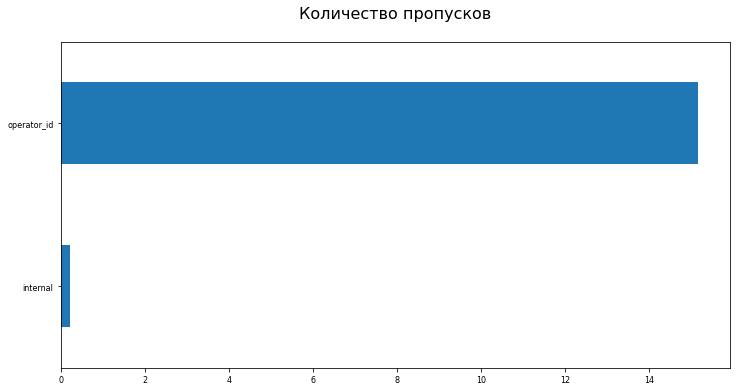

In [13]:
pass_value_barh(dataset)

Более 15% пропусков содержит столбец с информацией об ID оператора. Проверим, какие данные стоят за пропусками в этом столбце.

In [14]:
dataset.query('operator_id != operator_id').head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
30,166377,2019-08-13 00:00:00+03:00,in,False,NaN,True,7,0,128
38,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
77,166377,2019-08-22 00:00:00+03:00,in,False,NaN,True,1,0,1


Присутстует тенденция отсутствия данных по оператору на запись о пропущенном звонке. Проверим, есть ли пропуски на принятых вызовах.

In [15]:
dataset.query('operator_id != operator_id & is_missed_call == False')['date'].count()

122

Таким образом большиенство пропусков по столбццу с оператором приходится на пропущенные звонки, что логично, т.к. звонок не принят, нет сведений об операторе. Также есть 122 записи принятых звонков с пропуском, в этом случае можно ссылаться на ошибки в сборе данных.

Для последующего упрощения работы с данными принимается заменить `NaN` на числовое значение. Примем `0`, и в дальнейшем анализе определяем `0` в столбцах `internal` и `operator_id` как отсутствие данных.

In [16]:
dataset = dataset.fillna(0)

#### Изменение типов данных

Датасет `clients` имеет несоответствие по типу данным о начале регестрации клиента, определяемые как `object`.

Таблица `dataset` имеет неверный тип данных по дате статистики (`object`), маркеру внутренних и внешних вызовов (`object`) и идентификатору оператора (`float64`). 

Приведем типы данных в соответствие.

In [17]:
# изменяем тип данных о дате статистики на `datetime`
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['date'] = dataset['date'].dt.date
dataset['date'] = pd.to_datetime(dataset['date'])

# изменяем тип данных о дате регестрации клиента на `datetime`
clients['date_start'] = pd.to_datetime(clients['date_start'])

# изменяем тип данных о маркере внутренних и внешних вызовов на `bool`
dataset['internal'] = dataset['internal'].astype(bool)

# изменяем тип данных идентификатора оператора на `int`
dataset['operator_id'] = dataset['operator_id'].astype(int)

#### Поиск дубликатов

Для исключения из датафрейма дубликатов, для начала проверим начичие явных дубликатов комбинацией методов `duplicated()` и `sum()`.

In [18]:
clients.duplicated().sum()

0

In [19]:
dataset.duplicated().sum()

4900

Исключаем из датафрейма явные дубликаты.

In [20]:
dataset = dataset.drop_duplicates().reset_index(drop = True)

#### Выявление аномалий в данных

Проверим представленные для исследования данные на наличие аномальных значений по длительности и количеству звонков.

Так как данные за день имеют несколько записей одного оператора, стоит сгруппировать по оператору и дате, подсчитать количество звонков, их продолжительность с ожиданием и без.

В сутки суммарная длительность звонков не может превышать 24 часа (1440 мин). Поставим ограничение на гистограмму.

In [21]:
# подготавливаем данные для изучения аномальных значений
dataset_anomaly = (
    dataset.groupby(['user_id', 'operator_id', 'date'])
    .agg({'total_call_duration':'sum', 'call_duration':'sum', 'calls_count':'sum'})
    .reset_index()
)
# переводим продолжительность звонков в минуты
dataset_anomaly['total_call_duration'] = np.ceil(dataset_anomaly['total_call_duration']/60)
dataset_anomaly['call_duration'] = np.ceil(dataset_anomaly['call_duration']/60)

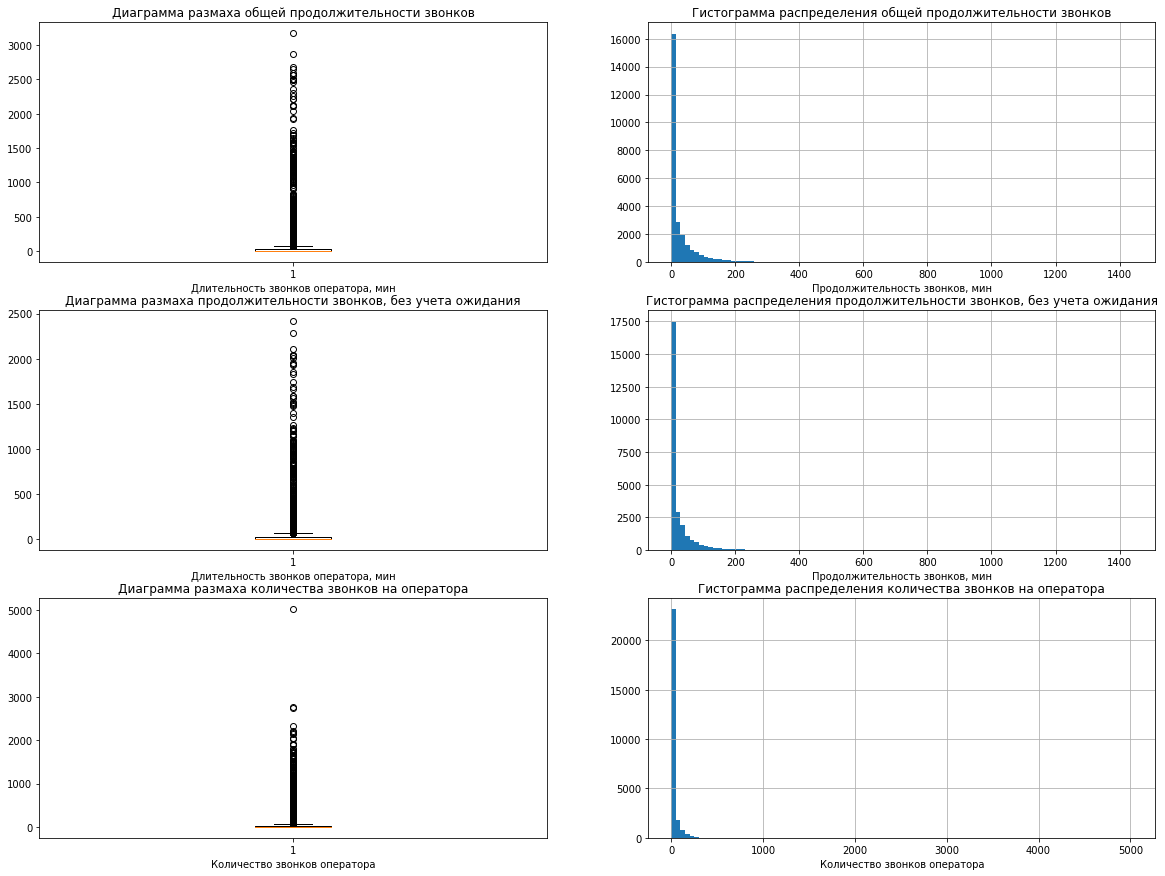

In [22]:
# задаём размер сетки для графиков
plt.figure(figsize=(20, 15))

# в таблице графиков —  три строки и два столбца, шесть ячеек
# в первой строим диаграмму размаха общей продолжительности звонков с учетом времени ожидания
ax1 = plt.subplot(3, 2, 1)
plt.boxplot(dataset_anomaly['total_call_duration'])
plt.xlabel('Длительность звонков оператора, мин')
plt.title('Диаграмма размаха общей продолжительности звонков')

# во второй ячейке гистограмму распределения общей продолжительности звонков с учетом времени ожидания
ax2 = plt.subplot(3, 2, 2)
(dataset_anomaly['total_call_duration']).hist(bins=100, range=(0, 1440))
plt.xlabel('Продолжительность звонков, мин')
plt.title('Гистограмма распределения общей продолжительности звонков')

# в третьей ячейке — диаграмма размаха продолжительности звонков без учетом времени ожидания
ax3 = plt.subplot(3, 2, 3)
plt.boxplot(dataset_anomaly['call_duration'])
plt.xlabel('Длительность звонков оператора, мин')
plt.title('Диаграмма размаха продолжительности звонков, без учета ожидания')

# в чётвертой ячейке — гистограмма распределения продолжительности звонков без учетом времени ожидания
ax4 = plt.subplot(3, 2, 4)
(dataset_anomaly['call_duration']).hist(bins=100, range=(0, 1440))
plt.xlabel('Продолжительность звонков, мин')
plt.title('Гистограмма распределения продолжительности звонков, без учета ожидания')

# в пятой ячейке — диаграмма размаха количества звонков на оператора
ax5 = plt.subplot(3, 2, 5)
plt.boxplot(dataset_anomaly['calls_count'])
plt.xlabel('Количество звонков оператора')
plt.title('Диаграмма размаха количества звонков на оператора')

# в шестой ячейке — гистограмма распределения количества звонков
ax6 = plt.subplot(3, 2, 6)
dataset_anomaly['calls_count'].hist(bins=100)
plt.xlabel('Количество звонков оператора')
plt.title('Гистограмма распределения количества звонков на оператора')

plt.show()

Диаграммы размаха показывают наличие аномально высоких значений, как по количеству звонков, так и по их общей продолжительности. По гистограмме распределения заметно, что длительность звонков в общем не более 300 минут,  без учета ожидания менее 250 минут. Распространенное количество звонков у оператора меньше 400.

Принимая во внимание, что оператор работает смену в 12 часов по 60 минут, то максимальное количество минут должно соответствовать 12х60=720 минутам, соответственно и количество звонков не должно превышать 720.

In [23]:
print(f"Количество уникальных клиентов с высокими значениями по количеству и длительности вызовов оператора: "
    f"{dataset_anomaly.query('total_call_duration>720 | call_duration>720 | calls_count>720')['user_id'].nunique()}"
    )

Количество уникальных клиентов с высокими значениями по количеству и длительности вызовов оператора: 6


В данных присутствуют клиенты, операторы которых имеют аномально высокую продолжительность звонков, также высокое значение по количеству звонков. Определить причину возникновения по имеющимся данным не представляется возможным. Возможно технический сбой сбора информации, возможно непоследовательная работа самих операторов, что под одной учетной записью работает несколько человек. Проводить исключение аномальных значений не будем.

In [24]:
dataset_anomaly_user = dataset_anomaly.query('total_call_duration>720 | call_duration>720 | calls_count>720')
dataset_anomaly_user

,user_id,operator_id,date,total_call_duration,call_duration,calls_count
3248,166582,885876,2019-08-19,905.0,628.0,659
3250,166582,885876,2019-08-21,749.0,498.0,667
3251,166582,885876,2019-08-22,778.0,543.0,567
3252,166582,885876,2019-08-23,808.0,565.0,595
3255,166582,885876,2019-08-26,1014.0,756.0,594
...,...,...,...,...,...,...
25633,168361,0,2019-11-06,109.0,0.0,1291
25634,168361,0,2019-11-07,91.0,0.0,1085
25635,168361,0,2019-11-08,75.0,0.0,889
25655,168361,0,2019-11-28,27.0,0.0,748


#### Добавление новых столбцов

Для аналица динамики во времени добавим столбец с указанием месяца даты статистики, для исследовательского анализа переведем длительность звонков в минуты.

In [25]:
# добавление столбца с месяцем
dataset['month'] = dataset['date'].astype('datetime64[M]').dt.date

# перевед общей длительности звонков в минуты
dataset['total_call_duration_min'] = np.ceil(dataset['total_call_duration']/60)

# перевед длительности звонков без учета ожидания в минуты
dataset['call_duration_min'] = np.ceil(dataset['call_duration']/60)

#### Вывод по обработке данных

Таблица данных по клиентам не имеет пропусков, выборка данных по работе клиентов имеет пропуски по столбцу идентификатора оператора в 15% записей (8172) и по столбцу маркера внутренних и внешних вызовов менее 1% записей (пропуски в 117), пропуски принято заменить на значение "0". Изменен тип данных по столбцам даты регистрации клиента в сервисе и даты статистики на `datetime`. Изменен тип данных для столбца маркера внутренних и внешних вызовов на `bool` и идентификатора оператора на `int`.

Найдены явные дубликаты в данных и аномальные значения по длительности звонков и количеству звонков. Из датасета для исследования исключены записи дубликатов и аномальных значений.

Добавлен столбца с месяцом в датафрейм `dataset`.

### Шаг 2. Исследовательский анализ

Для исследования данных добавим тарифный план в таблицу `dataset`.

In [26]:
# добавим к выборке данных информацию о тарифном плане из таблицы клиентов
data_final = dataset.merge(clients, on='user_id', how='left')

#### Количество уникальных клиентов в клиентской базе и уникальные клиенты в выборке данных

In [27]:
# количество уникальных клиентов в клиентской базе
print(f'Количество уникальных клиентов в клиентской базе: {clients["user_id"].nunique()}')

# количество уникальных клиентов в выборке данных
print(f'Количество уникальных клиентов в выборке данных: {dataset["user_id"].nunique()}')

# количество уникальных операторов в выборке данных
print(f'Количество уникальных операторов в выборке данных: {dataset["operator_id"].nunique()}')

Количество уникальных клиентов в клиентской базе: 732
Количество уникальных клиентов в выборке данных: 307
Количество уникальных операторов в выборке данных: 1093


Количество уникальных клиентов в выборке, значительно меньше клиентов по базе данным. Можно предлположить, что некоторые клиенты еще не начали пользоваться услугами, либо у нас не полная выборка по всем клиентам.

#### Количество уникальных клиентов в разбивке по дням и месяцам

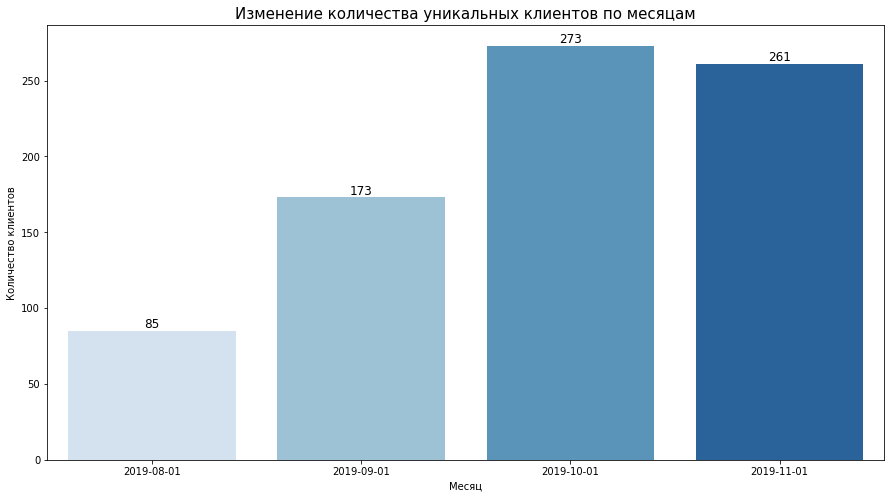

In [28]:
# подготавливаем таблицу количества клиентов в месяц, учитывая только уникальные id
clients_month = dataset.groupby('month').agg({'user_id':'nunique'}).sort_values(by='month').reset_index()

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
sns.barplot(x='month', y='user_id', data=clients_month, palette='Blues')

for i, val in enumerate(clients_month['user_id'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.title('Изменение количества уникальных клиентов по месяцам', fontsize=15)
plt.show()

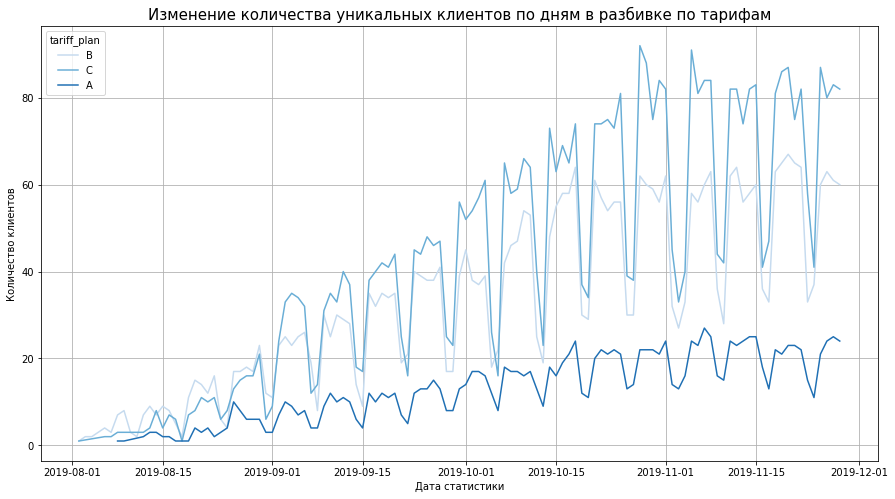

In [29]:
# подготавливаем таблицу сгруппированную по дням и тарифному плану с расчетом уникальных клиентов
clients_day = data_final.groupby(['date', 'tariff_plan']).agg({'user_id':'nunique'}).reset_index()

# строим линейный график изменения количества клиентов
plt.figure(figsize=(15,8))
sns.lineplot(data=clients_day, x='date', y='user_id', hue='tariff_plan', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Количество клиентов')
plt.title('Изменение количества уникальных клиентов по дням в разбивке по тарифам', fontsize=15)
plt.show()

Количество уникальных клиентов растет с августа по сентябрь, а в ноябре снизилось на 12 клиентов. В рассмотрении динамики притока клиентов по разным тарифам заметны высокие темпы по тарифу `С` и `B`. Клиенты на тариф `A` приходят медленнее, их количество практически стабильно последние два месяца.

#### Количество уникальных операторов в разбивке по дням и месяцам

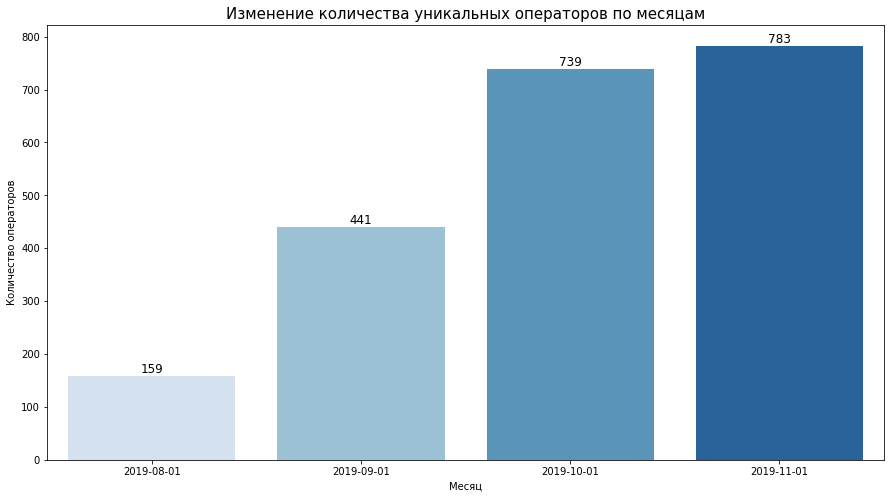

In [30]:
# подготавливаем таблицу количества операторов в месяц, учитывая только уникальные id
operators_month = dataset.groupby('month').agg({'operator_id':'nunique'}).sort_values(by='month').reset_index()

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
sns.barplot(x='month', y='operator_id', data=operators_month, palette='Blues')

for i, val in enumerate(operators_month['operator_id'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Месяц')
plt.ylabel('Количество операторов')
plt.title('Изменение количества уникальных операторов по месяцам', fontsize=15)
plt.show()

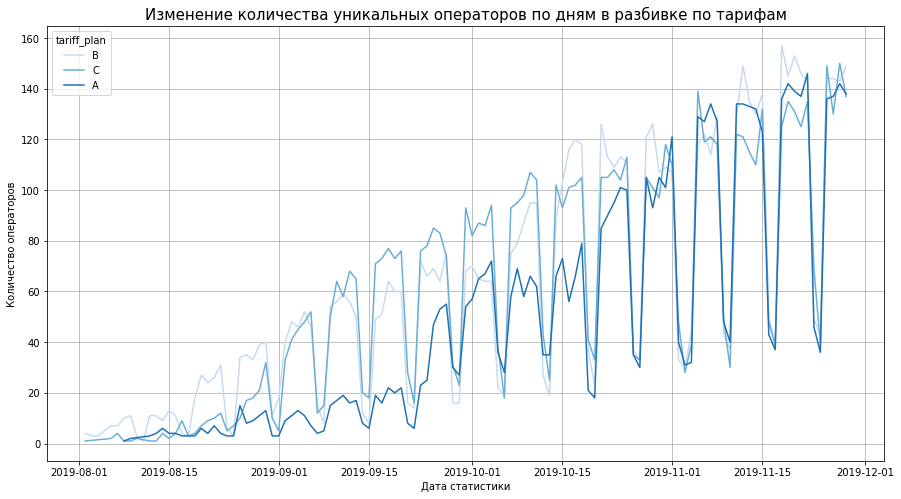

In [31]:
# подготавливаем таблицу сгруппированную по дням и тарифному плану с расчетом уникальных операторов
operator_day = data_final.groupby(['date', 'tariff_plan']).agg({'operator_id':'nunique'}).reset_index()

# строим линейный график изменения количества операторов
plt.figure(figsize=(15,8))
sns.lineplot(data=operator_day, x='date', y='operator_id', hue='tariff_plan', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Количество операторов')
plt.title('Изменение количества уникальных операторов по дням в разбивке по тарифам', fontsize=15)
plt.show()

С операторами ситуация более позитивная, их количество растет с каждым днем до даты проведения исследования.

В динамике по дням заметны необычные скачки по одному двум дням, возможно какие-то клиенты работают с определенной периодичностью, возможно в какие-то из дней не проводилась статистика по некоторым клиентам.

Несмотря на то, что уникальное количество пользователей на тарифе А в последние месяцы стабильно, количество уникальных операторов растет. А к концу периода количество операторов, работающих на каждом тарифе примерно одинаково, хотя распределение по клиентам различается.

#### Динамика длительности звонков 

Посмотрим на активность клиентов разных тарифов, для этого представим график изменения средней длительности звонка.

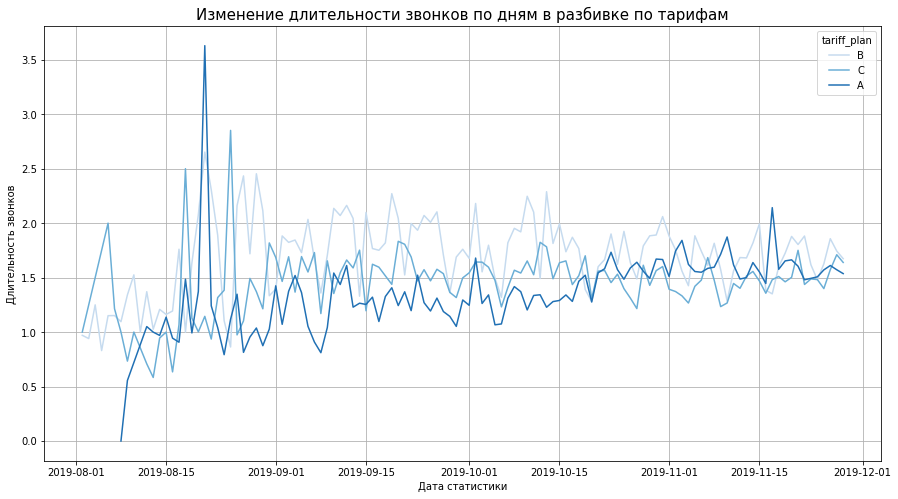

In [32]:
# подготавливаем таблицу, добваляем столбец с продолжительностью одного звонка на тарифе
calls_total = data_final
calls_total['duration'] = calls_total['total_call_duration_min']/calls_total['calls_count']

calls_total_dur = calls_total.groupby(['date', 'tariff_plan']).agg({'duration':'mean'}).reset_index()

# строим линейный график изменения количества операторов
plt.figure(figsize=(15,8))
sns.lineplot(data=calls_total_dur, x='date', y='duration', hue='tariff_plan', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Длительность звонков')
plt.title('Изменение длительности звонков по дням в разбивке по тарифам', fontsize=15)
plt.show()

Проверим, аналогична ли ситуация, если не учитывать время ожидания.

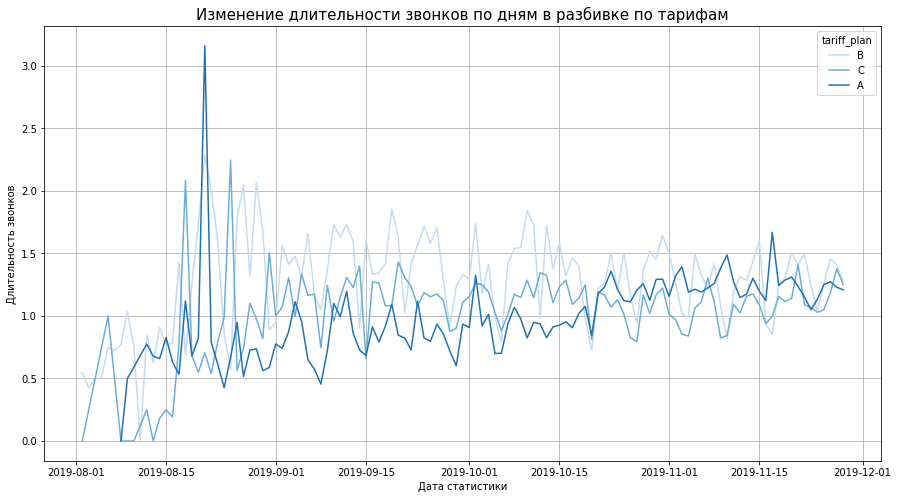

In [33]:
# подготавливаем таблицу, добваляем столбец с продолжительностью одного звонка на тарифе без учета ожидания
calls_total['duration_call'] = calls_total['call_duration_min']/calls_total['calls_count']

calls_total_dur2 = calls_total.groupby(['date', 'tariff_plan']).agg({'duration_call':'mean'}).reset_index()

# строим линейный график изменения количества операторов
plt.figure(figsize=(15,8))
sns.lineplot(data=calls_total_dur2, x='date', y='duration_call', hue='tariff_plan', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Длительность звонков')
plt.title('Изменение длительности звонков по дням в разбивке по тарифам', fontsize=15)
plt.show()

Посмотрим на динамику исходящих звонков.

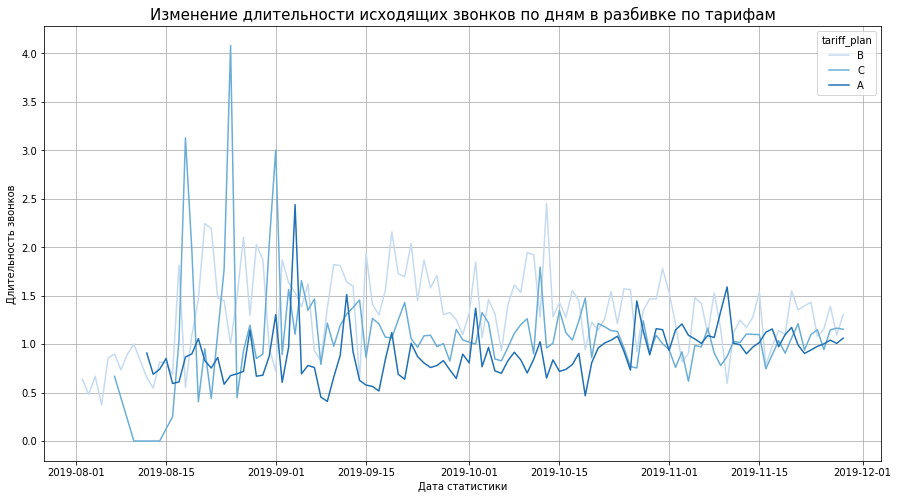

In [34]:
calls_total_out = calls_total.query('direction=="out"').reset_index()
calls_total_out['duration_call'] = calls_total_out['call_duration_min']/calls_total_out['calls_count']
calls_total_out = calls_total_out.groupby(['date', 'tariff_plan']).agg({'duration_call':'mean'}).reset_index()

# строим линейный график изменения количества операторов
plt.figure(figsize=(15,8))
sns.lineplot(data=calls_total_out, x='date', y='duration_call', hue='tariff_plan', palette='Blues')
plt.grid()
plt.xlabel('Дата статистики')
plt.ylabel('Длительность звонков')
plt.title('Изменение длительности исходящих звонков по дням в разбивке по тарифам', fontsize=15)
plt.show()

Динамика продолжительности звонков с ожиданием и без аналогична, при том что длительность звонков без учета ожидания меньше. Изначально длительность увеличивалась, но с сентября приблизительно на одном уровне. Наибольшая продолжительность наблюдается по тарифу `B`, затем `C` и `A`. К моменту проведения исследования средняя продолжительность на всех тарифах близка к одному значению. Продолжительность исходящих звонков на протяжении всего периода наблюдения по тарифу `B` превышает другие тарифы, за исключением пиковых значений в конце августа и начале сентября по тарифам `C` и `A`.

#### Выделение направления работы колл-центров по количеству входящих и исходящих звонков

Согласно тарифным планам, входящие звонки не оплачиваются, в силу этого для компании выгоднее иметь клиентов, совершающих исходящие звонки. Рассмотрим распределение звонков по направлению. Для начала рассчитаем общее количество звонков в каждом направлении по всем клиентам.

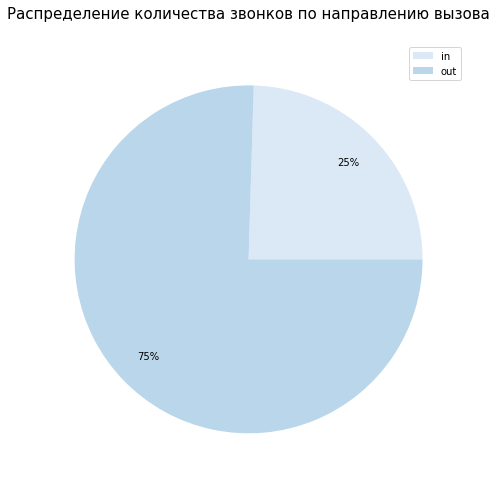

In [35]:
# группируем таблицу сводную таблицу по направлению и посчитаем количество звонков
direction_data = dataset.groupby('direction').agg({'calls_count':'sum'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(direction_data['calls_count'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение количества звонков по направлению вызова' + "\n", fontsize=15)
plt.legend(direction_data['direction'])
plt.show()

75% от всех звонков является исходящими. Рассмотрим статитстику в разрезе каждокого клиента, сгруппируем клиентов компании по преобладающему направлению звонков, совершенных за наблюдаемый период.

In [36]:
# создаем пустую таблицу, для добавления в нее уникального клиента и преимущественного направления звонков
clients_direct = pd.DataFrame({
    'user_id': [], 
    'direction': [], 
    })
# таблица для клиентов с одним направлением звонков
clients_direct_only = pd.DataFrame({
    'user_id': [], 
    'direction': [], 
    })

# циклом перебираем уникальных клиентов
for i in dataset['user_id'].unique():

    # создаем таблицу для клиента с группировкой по направлению звонков и суммированием количества звонков, 
    # сортировка по алфавиту
    df = (
        dataset.query('user_id == @i').groupby('direction')['calls_count'].agg({'sum'})
        .sort_values(by='direction', ascending = True).reset_index()
    )
    
    # условие для разделения клиентов, у которых два направления или одно
    if df.shape[0] > 1:
        
        # сравниваем количество исходящих и входящих звонков
        if df.loc[0, 'sum'] > df.loc[1, 'sum']:
           
           # если больше входящих в таблицу добавляем запись с id клиента и направление in
           clients_direct.loc[ len(clients_direct.index )] = [i, 'in'] 
        else:
           # если больше исходящих в таблицу добавляем запись с id клиента и направление out
           clients_direct.loc[ len(clients_direct.index )] = [i, 'out']
    else:
        # для клиентов с одним направление в переменную dir  выносим направление звонка и вносим запись в таблицу
        dir = df.loc[0, 'direction']
        dir2 = df.loc[0, 'direction']
        
        clients_direct.loc[ len(clients_direct.index )] = [i, dir]
        clients_direct_only.loc[ len(clients_direct.index )] = [i, dir2]

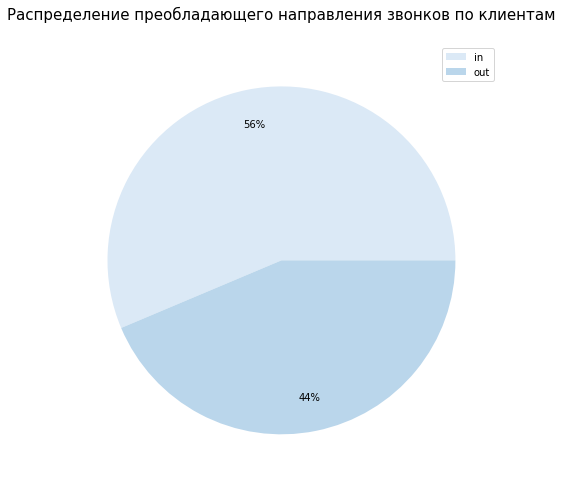

In [37]:
# группируем таблицу сводную таблицу по клиентам и направлению звонков
clients_direct = clients_direct.groupby('direction').agg({'user_id':'count'}).sort_values(by='direction').reset_index()

# строим круговую диаграмму для визуализации распределения клиентов по преобладающему типу звонков
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(clients_direct['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение преобладающего направления звонков по клиентам' + "\n", fontsize=15)
plt.legend(clients_direct['direction'])
plt.show()

В рассмотрении каждого клиента индивидуально, в большинстве случаев преобладает количество входящих звонков. Возможно есть клиенты, получающие исключительно входящие звонки. Выведем `id` клиентов, операторы которых только принимают входящие звонки.

In [38]:
# выведем id клиентов с одним направлением звонков
clients_direct_only.groupby('direction').agg({'user_id':'count'}).reset_index()

,direction,user_id
0,in,85


Итого 85 клиентов компании только принимают звонки, и не совершают исходящих, даже внутри сети, звонков.

#### Количество клиентов в разбивке по тарифам компании

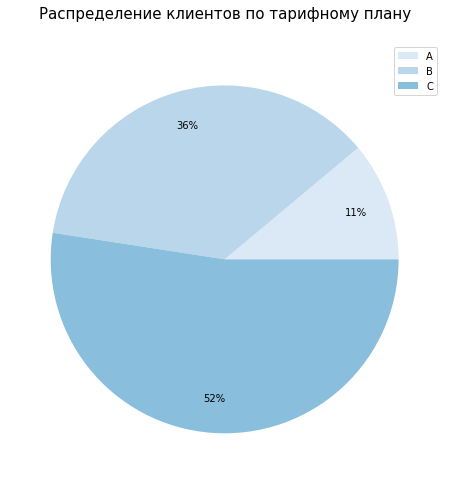

,tariff_plan,user_id
0,A,34
1,B,112
2,C,161


In [39]:
# группируем таблицу сводную таблицу по тарифному плану и посчитаем количество уникальных клиентов
clients_tariff = data_final.groupby('tariff_plan').agg({'user_id':'nunique'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(clients_tariff['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение клиентов по тарифному плану' + "\n", fontsize=15)
plt.legend(clients_tariff['tariff_plan'])
plt.show()

clients_tariff

Чем дешевле тариф, тем больше клиентов его использует. Так тариф `С` имеет более половины клиентов, а тариф `А` только 11%.

#### Количество опператоров в разбивке по тарифам компании 

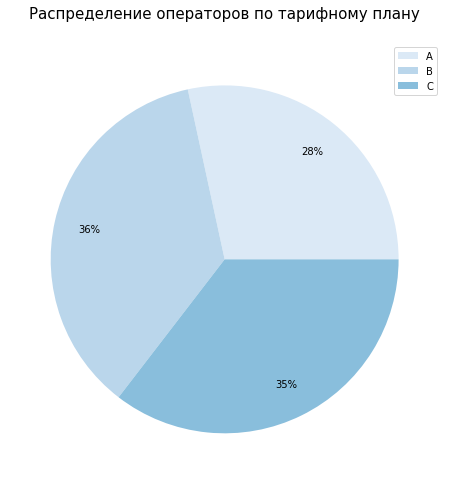

,tariff_plan,operator_id
0,A,311
1,B,396
2,C,388


In [40]:
# группируем таблицу сводную таблицу по тарифному плану и посчитаем количество уникальных операторов
operators_tariff = data_final.groupby('tariff_plan').agg({'operator_id':'nunique'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(operators_tariff['operator_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение операторов по тарифному плану' + "\n", fontsize=15)
plt.legend(operators_tariff['tariff_plan'])
plt.show()

operators_tariff

Анализ операторов более интересен, так как здесь уже не наблюдается распределение в зависимости от стоимости тарифа, количество операторов на тарифах отличается на 8 % максимум. Исходя из того, что компаний с тарифом `А` много меньше, чем на тарифе `В` или `С`, то они имеют большее количество операторов. 

#### Среднее количество операторов у клиентов с разными тарифами

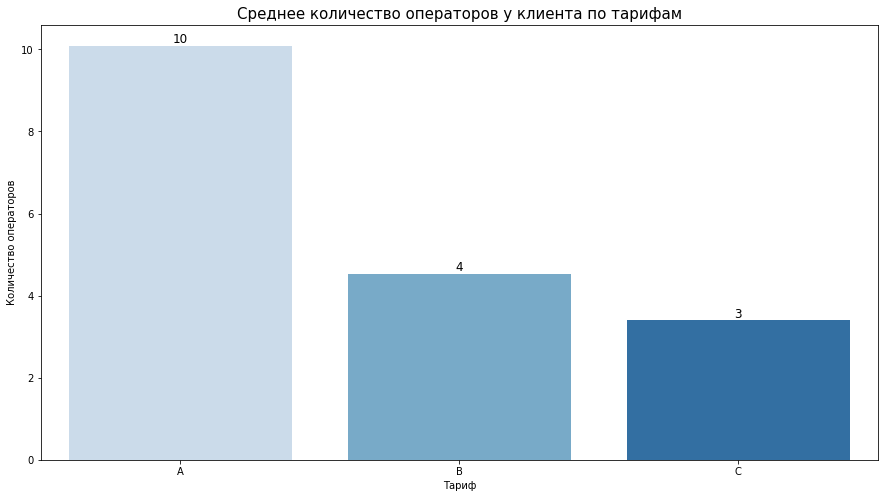

In [41]:
# создадим таблицу, сгруппированную по тарифам и клиентам с рассчетом их операторов
clients_operators = (
    data_final.groupby(['tariff_plan','user_id']).agg({'operator_id':'nunique'}).reset_index()
    .groupby('tariff_plan').agg({'operator_id':'mean'}).sort_values(by='operator_id', ascending=False).reset_index().round(2)
)

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
sns.barplot(x='tariff_plan', y='operator_id', data=clients_operators, palette='Blues')

for i, val in enumerate(clients_operators['operator_id'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

plt.xlabel('Тариф')
plt.ylabel('Количество операторов')
plt.title('Среднее количество операторов у клиента по тарифам', fontsize=15)
plt.show()

Вывод из предыдущего действия подтвержден, количество операторов в компаниях с тарифом `А` (10) превышает количество операторов с другими тарифами (4-3).

#### Среднее количество и продолжительность исходящих внутренних звонков у клиентов с разными тарифами

Средие показатели будем рассчитывать по работе операторов в месяц.

In [42]:
# создадим таблицу, сгруппировав по тарифам, клиентам и операторам, 
# с расчетом количества звонков и средней продолжительности звонков

clients_calls_internal = (
    data_final.query('internal == True & direction == "out"')
    .groupby(['tariff_plan','user_id', 'operator_id', 'month']).agg({'calls_count':'count', 'total_call_duration_min':'sum'})
    .reset_index()
    .groupby('tariff_plan').agg({'calls_count':'mean', 'total_call_duration_min':'mean'})
    .reset_index().round(0)
)
clients_calls_internal

,tariff_plan,calls_count,total_call_duration_min
0,A,7.0,23.0
1,B,5.0,15.0
2,C,6.0,11.0


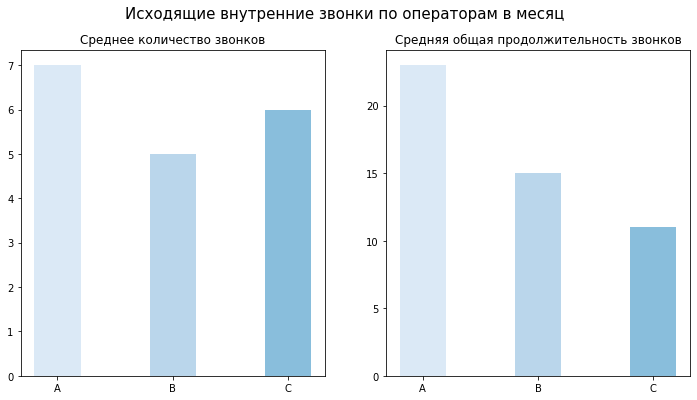

In [43]:
# график средних показателей по исходящим внутренним звонкам оператора в месяц
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = sns.color_palette('Blues')
axs[0].bar(clients_calls_internal['tariff_plan'], clients_calls_internal['calls_count'], color = colors, width = 0.4)
axs[1].bar(clients_calls_internal['tariff_plan'], clients_calls_internal['total_call_duration_min'], color = colors, width = 0.4)
fig.suptitle('Исходящие внутренние звонки по операторам в месяц' + "\n"*2, fontsize=15)
axs[0].set_title('Среднее количество звонков')
axs[1].set_title('Средняя общая продолжительность звонков')
plt.show()

Оценивая количество внутренних звонков, можно считать, что отличий в работе операторов по тарифам нет. А продолжительность этих звонков по тарифу тем больше, чем больше лимит в тарифе, т.е. наиболее продолжительные разговоры ведут по тарифу `А`, наименее по тарифу `С`.

#### Среднее количество и продолжительность исходящих внешних звонков у клиентов с разными тарифами

In [44]:
# создадим таблицу, сгруппировав по тарифам, клиентам и операторам, 
#с расчетом количества звонков и средней продолжительности звонков

clients_calls_out = (
    data_final.query('internal == False & direction == "out"')
    .groupby(['tariff_plan','user_id', 'operator_id', 'month']).agg({'calls_count':'count', 'total_call_duration_min':'sum'})
    .reset_index()
    .groupby('tariff_plan').agg({'calls_count':'mean', 'total_call_duration_min':'mean'})
    .reset_index().round(0)
)
clients_calls_out

,tariff_plan,calls_count,total_call_duration_min
0,A,15.0,913.0
1,B,14.0,243.0
2,C,15.0,304.0


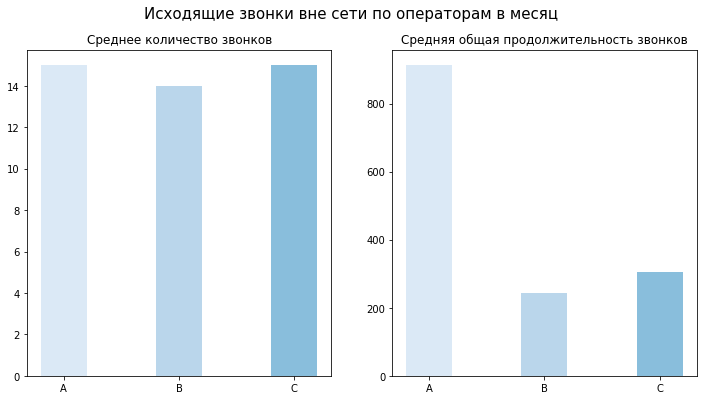

In [45]:
# график средних показателей по исходящим внешним звонкам оператора в месяц
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
colors = sns.color_palette('Blues')
axs[0].bar(clients_calls_out['tariff_plan'], clients_calls_out['calls_count'], color = colors, width = 0.4)
axs[1].bar(clients_calls_out['tariff_plan'], clients_calls_out['total_call_duration_min'], color = colors, width = 0.4)
fig.suptitle('Исходящие звонки вне сети по операторам в месяц' + "\n"*2, fontsize=15)
axs[0].set_title('Среднее количество звонков')
axs[1].set_title('Средняя общая продолжительность звонков')
plt.show()

Количество исходящих звонков вне сети также не имеет явных лидеров среди тарифа. Можно отметить низкую продолжительность звонка по тарифу `В` и много первышающую среднюю продолжительность по тарифу `A`.

#### Вывод исследовательского анализа

Для исследования представлена база с уникальными 732 клиентами, выборка данных по 307 клиентам и 1093 их отператоров. В течении периода наблюдения замечен рост количества уникальных клиентов с августа по сентябрь, к ноябрю выявлен спад количества клиентов. По операторам идет рост уникальных кадров практически с каждом днем до дня исследования. Замечена тенденция отсутствия данных статистики по клиентам с некой периодичностью, в следствие чего может быть сделано предположение о непостоянной роботе клиентов, либо некорректном сборе данных.

Более половины клиентов имеют преобладание входящих звонков над исходящими. В целом исходящих звонков больше, чем входящих. Из всех клиентов компании 85 не совершают исходящих звонков.

В распределении по тарифам имеются следующие данные:

 Тариф | Клиенты | Операторы | Среднее число операторов | Среднее кол-во исход.внутр. | Прод-ть исход.внутр. | Среднее кол-во исход.внеш. | Прод-ть исход.внеш.
:-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: 
А | 34 | 311 | 10 | 7 | 23 | 15 | 913
B | 112 | 396 | 4 | 5 | 15 | 14 | 243
C | 161 | 388 | 3 | 6 | 11 | 15 | 304   



### Шаг 3. Расчет получаемой выручки компании

Для расчета выручки, необходимо подготовить таблицу, которая будет содержать помесячные данные о потреблении услуг клиентами.

In [46]:
# напишем функцию для сбора данных по каждому клиенту в отдельную таблицу
# для работы функции на ввод подаются: таблица клиентской базы, датасет с выборкой статистики постребления услуг, данные о тарифном плане
def revenue(clients, dataset, tariff_plan):

    # пустая таблица для записи данных о каждом клиенте
    revenue = pd.DataFrame({
       'user_id': [], # id клиента
       'tariff': [], #тариф клиента
       'month': [], #месяц сбора данных
       'operators': [], #количество уникальных операторов
       'call_in': [], #длительность исходящих звонков внутри сети
       'over_limit': [], #превышение лимита длительности исходящих звонков внутри сети по тарифному плану
       'call_out': [], #длительность исходящихх звонков вне сети
       'payment': [] #итоговая оплата за месяц
        })
    
    # объединение выборки данных с клиентской базой
    df = dataset.merge(clients, on='user_id', how='left')
    
    # цикл для рассмотрения каждого клиента
    for i in dataset['user_id'].unique():
        
        # таблица с данными клиента за весь период
        df_i = df.query('user_id == @i')

        # цикл для рассмотрения каждого месяца
        for j in df_i['month'].unique():
            
            
            df_j = df_i.query('month == @j').reset_index() # таблица с данными клиента за месяц для расчета платы            
            tariff = df_j.loc[0, 'tariff_plan'] # определение тарифа клиента            
            tariff_plan_j = tariff_plan.query('name == @tariff').reset_index() # данные о тарифе клиента                    
            operatots = df_j['operator_id'].nunique() # количество операторов в месяц j
            
            # исключение из таблицы входящих звонков, т.к. они бесплатны
            df_j = df_j.query('direction == "out"')

            # длительность исходящих звонков внутри сети в минутах за месяц j
            call_in = np.ceil(df_j.query('internal == True')['total_call_duration'].sum()/60)
            # длительность исходящих звонков вне сети в минутах за месяц j
            call_out = np.ceil(df_j.query('internal == False')['total_call_duration'].sum()/60)

            revenue_j = (tariff_plan_j.loc[0, 'payment'] # ежемесячная оплата тарифа
                        + operatots * tariff_plan_j.loc[0, 'payment_operator'] # доплата за каждого оператора
                        + call_out * tariff_plan_j.loc[0, 'outgoing_call'] # оплата исходящих звонков вне сети
                        )
            #условием проверяем перерасход лимита исходящих звонков внутри сети и добавляем результат к выручке за месяц
            if call_in > tariff_plan_j.loc[0, 'call_network']:
                revenue_j += (call_in - tariff_plan_j.loc[0, 'call_network']) * tariff_plan_j.loc[0, 'price_over_limit']
                over_limit = call_in - tariff_plan_j.loc[0, 'call_network']
            else:
                revenue_j += 0
                over_limit = 0
            
            # дабавляем в таблицу запись об используемых услугах за месяц
            revenue.loc[len(revenue.index)] = [i, tariff, j, operatots, round(call_in, 2), round(over_limit, 2), round(call_out, 2), round(revenue_j, 2)]
    # перевод типа данных в соответствующий вид
    revenue['user_id'] = revenue['user_id'].astype(int)
    revenue['operators'] = revenue['operators'].astype(int)
    revenue['call_in'] = revenue['call_in'].astype(int)
    revenue['over_limit'] = revenue['over_limit'].astype(int)
    revenue['call_out'] = revenue['call_out'].astype(int)
    revenue = revenue.sort_values(by=['month', 'operators', 'user_id'])
    return revenue

Применим функцию к исследуемым данным.

In [47]:
revenue_final = revenue(clients, dataset, tariff_plan)

In [48]:
# выведем первые записи получившейся таблицы
revenue_final.head()
revenue_final['month'] = pd.to_datetime(revenue_final['month'])
#revenue_final['month'] = revenue_final['month'].dt.date
revenue_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 34 to 721
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     792 non-null    int64         
 1   tariff      792 non-null    object        
 2   month       792 non-null    datetime64[ns]
 3   operators   792 non-null    int64         
 4   call_in     792 non-null    int64         
 5   over_limit  792 non-null    int64         
 6   call_out    792 non-null    int64         
 7   payment     792 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 55.7+ KB


#### Выручка компании по месяцам

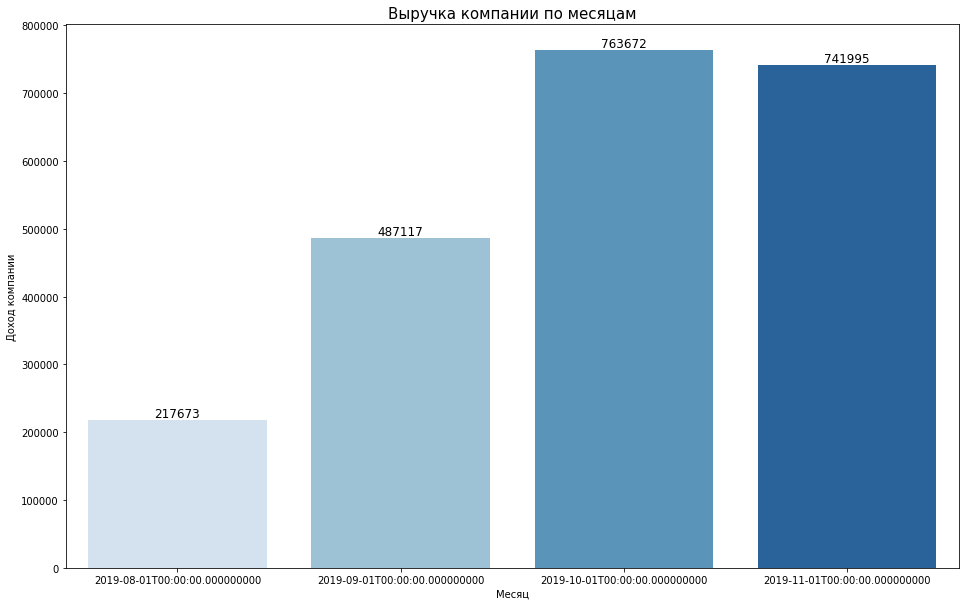

In [49]:
# таблица для граффика месячной выручки
rev_month = revenue_final.groupby('month').agg({'payment': 'sum'}).sort_values(['month']).reset_index().round()
#rev_month['month']=rev_month['month'].dt.date
# строим столбчатую диаграмму 
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x='month', y='payment', data=rev_month, palette='Blues')
for i, val in enumerate(rev_month['payment'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xlabel('Месяц')
plt.ylabel('Доход компании')
plt.title('Выручка компании по месяцам', fontsize=15)
plt.show()

In [50]:
print(f"Общая выручка компании за рассматриваемый период: {revenue_final['payment'].sum().round()}")

Общая выручка компании за рассматриваемый период: 2210457.0


Выручка компании растет с каждым месяцем. Быстрый подъем с августа к сентябрю может быть обусловлен началом работы в августе и активным приростом новых клиентов первым месяц. В ноябре выручка снизилась, как раз возможно из-за ухода некоторых клиентов, исходя из исследовательского анализа. За весь период выручка компании составила 2 210 457.

#### Средняя месячная выручка компании

In [51]:
print(f'Средняя месячная выручка за весь период: {rev_month["payment"].mean().round(2)}')

Средняя месячная выручка за весь период: 552614.25


Также в связи с меньшим доходом по августу средняя выручка за период данных статистики много больше августовского показателя, и меньше ноябрьского. Посчитаем среднюю выручку за более стабильные месяцы с сентября по ноябрь.

In [52]:
# cредняя месячная выручка за три месяца
revenue_mean = rev_month.query('month != "2019-08-01"')["payment"].mean().round(2)

print(f'Средняя месячная выручка за три месяца: {revenue_mean}')

Средняя месячная выручка за три месяца: 664261.33


Средняя выручка за период с сентября по ноябрь точнее характеризует работу компании, среднее значение в 664 261 уже ближе к выручке, получаемой последние месяцы.

#### Выручка компании в разбивке по тарифам

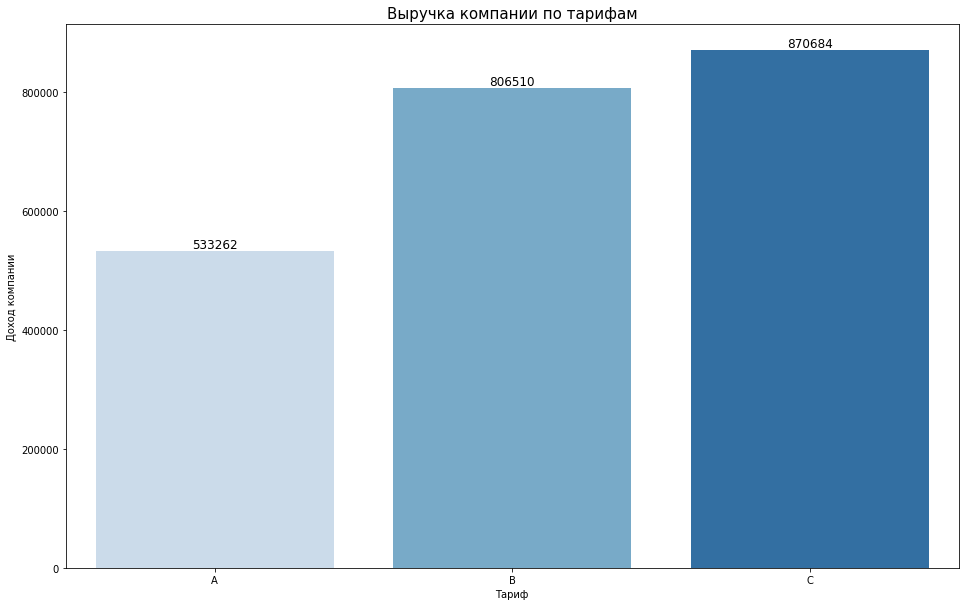

In [53]:
# таблица для граффика месячной выручки
rev_tariff = revenue_final.groupby('tariff').agg({'payment': 'sum'}).sort_values(['payment']).reset_index().round(2)

# строим столбчатую диаграмму 
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x='tariff', y='payment', data=rev_tariff, palette='Blues')
for i, val in enumerate(rev_tariff['payment'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xlabel('Тариф')
plt.ylabel('Доход компании')
plt.title('Выручка компании по тарифам', fontsize=15)
plt.show()

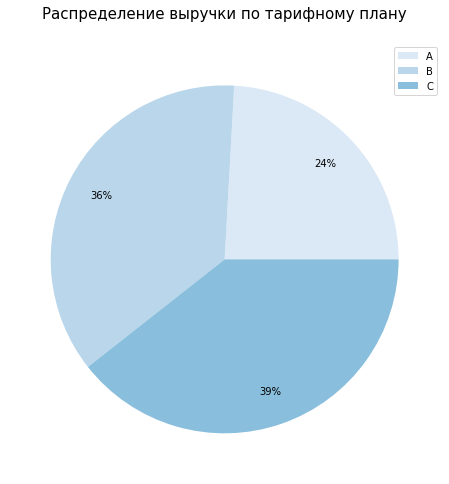

In [54]:
# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(rev_tariff['payment'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение выручки по тарифному плану' + "\n", fontsize=15)
plt.legend(rev_tariff['tariff'])
plt.show()

39% прибыли компания получает по клиентам по тарифу `C`, 36% приходится на тариф `В` и 24% на тарифный план `А`.

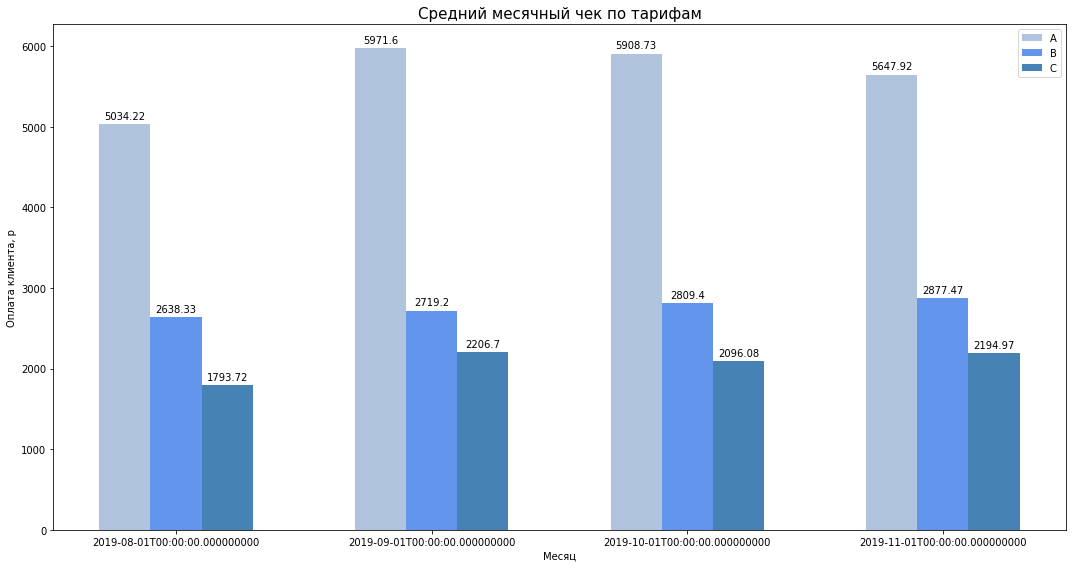

In [55]:
# подготовим таблицу для изучения месячной динамики средней платы по тарифу
revenue_final_tariff = revenue_final.groupby(['tariff', 'month']).agg({'payment':'mean'}).reset_index().round(2)
#revenue_final_tariff['month'] = revenue_final_tariff['month'].dt.date

# строим столбчатую диаграмму 
labels = list(revenue_final_tariff['month'].unique())
one = list(revenue_final_tariff.query('tariff=="A"')['payment'])
two = list(revenue_final_tariff.query('tariff=="B"')['payment']) 
three = revenue_final_tariff.query('tariff=="C"')['payment'] 

x = np.arange(len(labels))  # положение подписи 
width = 0.6  # ширина столбца

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width/3, one, width/3, label='A', color='lightsteelblue')
rects2 = ax.bar(x, two, width/3, label='B', color='cornflowerblue')
rects3 = ax.bar(x + width/3, three, width/3, label='C', color='steelblue')

# подписи для оси х и расположение подписи
ax.set_xlabel('Месяц')
ax.set_ylabel('Оплата клиента, р')
ax.set_title('Средний месячный чек по тарифам', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """расположение подписи над каждым баром"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() /2, height),
                    xytext=(0, 3),  # расстояние подписи над баром
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

#### Вывод по анализу выручки компании

Выручка компании растет с каждым месяцем с августа к октябрю, так в августе компания заработала 217673 р, в сентябре - 487117 р, в октябре 763672 р, но в ноябре снизилась к 714995 р. 

Общая выручка за все четыре месяца составляет 2210457 р., при средней в месяц 552614,25 р, а за активные последние 3 месяца средняя выручка составляет 664261,33 р.

Больший вклад в выручку  приносят клиенты по тарифу `В` и `С`, 36% и 39% соответственно. На тариф `A` приходится 24% всей выручки.

По среднемесячным показателям большая плата соответствует клиентам с тарифом `A`, и превышает остальные в 2 раза, но при этом снижается с сентября, от 5971 до 5647 р/мес. По тарифу `В` в среднем оплата растет, от 2638 к 2877 р/мес, а по тарифу `С` последние три месяца примерно на одном уровне, 2100-2200 р/мес.

### Шаг 4. Определение активных клиентов, их доли в общей совокупности клиентов компании, исследование эффективности используемых тарифов

#### Определение количества исходящих звонков за последний месяц

Определим последний месяц сбора данных из общей таблицы  и применим фильтрацию к итоговой таблице выручки.

In [56]:
last_month = dataset['month'].max()

Соберем таблицу наиболее активных клиентов по количеству исходящих звонков за последний месяц.

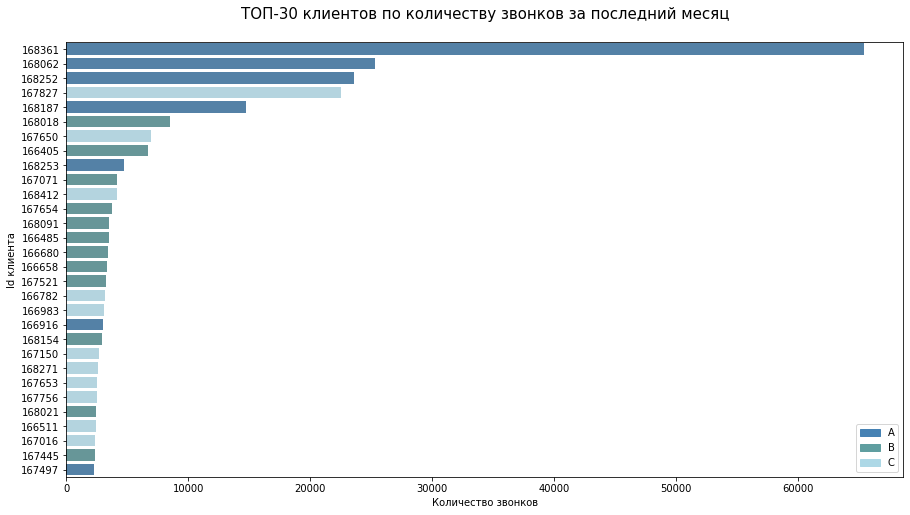

In [57]:
# таблица с количеством всех исходящих звонков по клиентам clients_last_month (clm)
clm = (
    dataset.query('month == @last_month').pivot_table(index=['user_id'], values='calls_count', aggfunc='sum')
    .sort_values(by='calls_count', ascending=False).head(150).merge(clients[['user_id', 'tariff_plan']], on='user_id')
    )

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='calls_count', y='user_id', data=clm.head(30), orient='h', palette=color, 
            order=clm.sort_values('calls_count', ascending = False).user_id.head(30))
# подписи графика
plt.xlabel('Количество звонков')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по количеству звонков за последний месяц' + "\n", fontsize = 15)
# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])

plt.show()

Проверим, настолько же активны клиенты, если принимать в расчет только исходящие звонки вне сети.

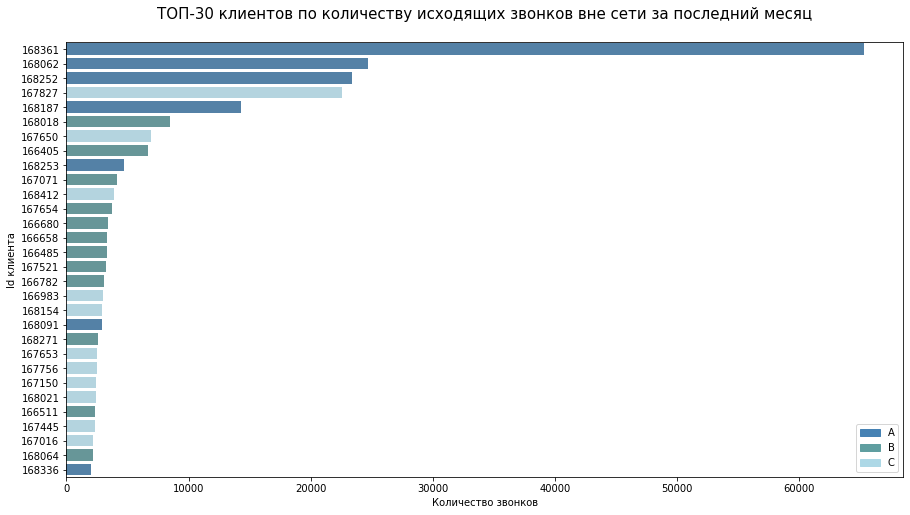

In [58]:
# таблица с количеством всех исходящих звонков по клиентам clients_last_month_out (clm_out)
clm_out = (
    dataset.query('month == @last_month & internal == False').pivot_table(index=['user_id'], values='calls_count', aggfunc='sum')
    .sort_values(by='calls_count', ascending=False).head(150).merge(clients[['user_id', 'tariff_plan']], on='user_id')
    )

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='calls_count', y='user_id', data=clm_out.head(30), orient='h', palette=color, 
            order=clm_out.sort_values('calls_count', ascending = False).user_id.head(30))
# подписи графика
plt.xlabel('Количество звонков')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по количеству исходящих звонков вне сети за последний месяц' + "\n", fontsize = 15)

# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])


plt.show()

Ситуация при исключении исходящих звонков внутри сети практически не изменилась, так что можно предположить, что клиенты топ-30 являются активными и выгодными для компании за счет большего количества исходящих звонков.

Выведем клиентов с наибольшей продолжительностью исходящих звонков, т.к. именно эта позиция интересует компанию, исходя из содержания тарифного плана.

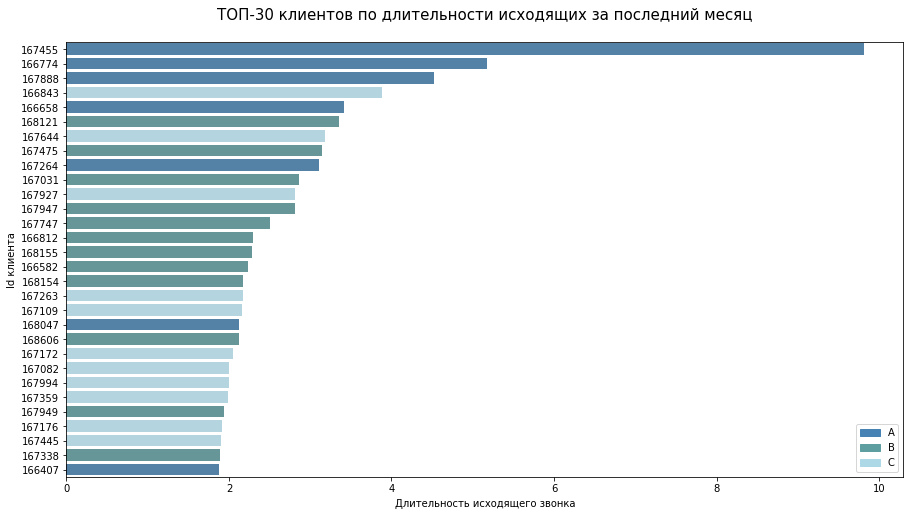

In [59]:
# таблица со средней продолжительностью исходящих звонков по клиентам в последний месяц clients_last_month_out_duration (clm_out_dur)
clm_out_dur = (
    dataset.query('month == @last_month & internal == False & direction == "out"').pivot_table(index=['user_id'], values=['calls_count', 'total_call_duration_min'], aggfunc='sum'))    
clm_out_dur['duration'] = round(clm_out_dur['total_call_duration_min']/clm_out_dur['calls_count'],2)
clm_out_dur=clm_out_dur.sort_values(by='duration', ascending=False).head(150).merge(clients[['user_id', 'tariff_plan']], on='user_id')
clm_out_dur

# строим столбчатую диаграмму 
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='duration', y='user_id', data=clm_out_dur.head(30), orient='h', palette=color, 
            order=clm_out_dur.sort_values('duration', ascending = False).user_id.head(30))
# подписи графика
plt.xlabel('Длительность исходящего звонка')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по длительности исходящих за последний месяц' + "\n", fontsize = 15)

# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])

plt.show()

По длительности звонков в лидерах клиенты с тарифом `С` и `B`. Из 30 клиентов с самыми длинными звонками всего 5 представителей тарифа `A`.


#### Распределение клиентов по вкладу в общую выручку компании за последний месяц, поиск наиболее выгодных клиентов для компании

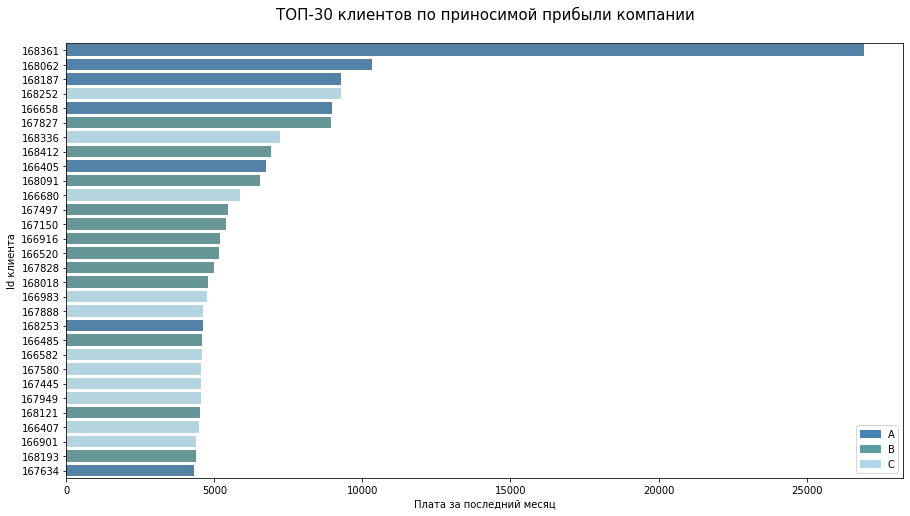

In [60]:
# таблица прибыли за последний месяц
clients_rev = revenue_final.query('month == @last_month').sort_values(by='payment', ascending=False).head(150)

# строим график топ-30 клиентов, вносимых наибольший вклад в выручку компании
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='payment', y='user_id', data=clients_rev.head(30), orient='h', palette=color, 
            order=clients_rev.sort_values('payment', ascending = False).user_id.head(30))
# подписи графика
plt.xlabel('Плата за последний месяц')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по приносимой прибыли компании' + "\n", fontsize = 15)

# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])

plt.show()

В соответствии с количеством исходящих звонков наибольшую прибыль в компанию приносят клиенты с id 168062, 168361 и 168187, относящиеся к тарифу `A`.

#### Расчет количества пропущенных звонков на последний месяц

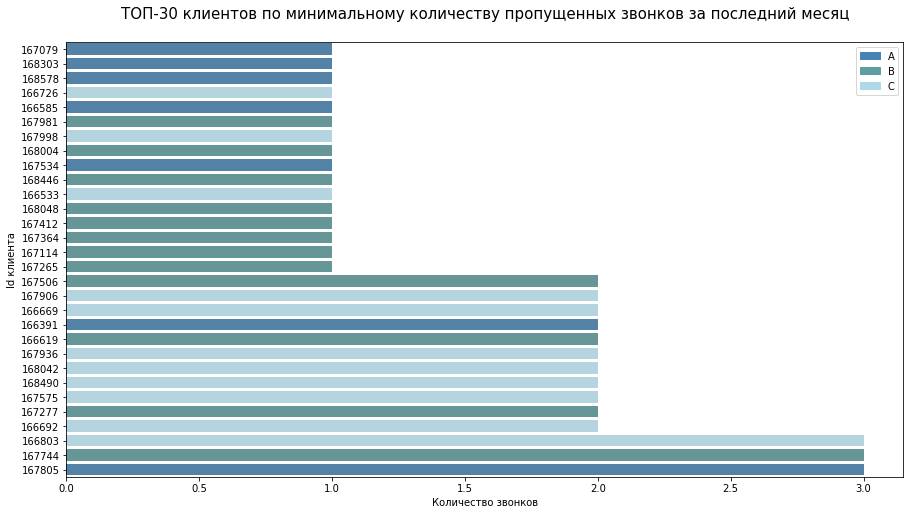

In [61]:
# таблица с минимальным количеством пропущенных звонков по клиентам clients_last_month_missed (clm_missed)
clm_missed = (
    dataset.query('month == @last_month & is_missed_call == True & internal == False').pivot_table(index=['user_id'], values='calls_count', aggfunc='sum')
    .sort_values(by='calls_count', ascending=True).head(150).merge(clients[['user_id', 'tariff_plan']], on='user_id')
    )

# строим график топ-30 клиентов с минимальным количеством пропущенных звонков за последний месяц
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='calls_count', y='user_id', data=clm_missed.head(30), orient='h', palette=color, 
            order=clm_missed.user_id.head(30))
# подписи графика
plt.xlabel('Количество звонков')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по минимальному количеству пропущенных звонков за последний месяц' + "\n", fontsize = 15)

# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])

plt.show()

In [62]:
# среднее число пропущенных звонков за последний месяц среди 100 клиентов с наименьшим кол-вом пропущенных звонков
clm_missed['calls_count'].mean()

17.72

По количеству пропущенных звонков может быть некоректно рассматривать активность клиента, т.к. это количество может тесно коррелировать с общим количеством звонков, так если клиент не активен, ему поступает меньше звонков, соответственно мало пропускает.


#### Распределение клиентов по количеству операторов в последнем месяце

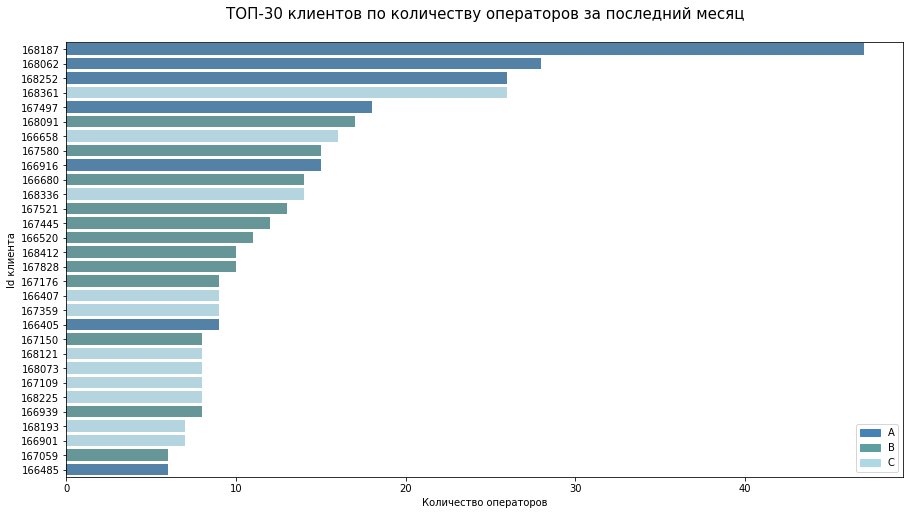

In [63]:
# таблица с количеством операторов по клиентам clients_last_month_operators (clm_operators)
clm_operators = (
    dataset.query('month == @last_month').pivot_table(index=['user_id'], values='operator_id', aggfunc='nunique')
    .sort_values(by='operator_id', ascending=False).head(150).merge(clients[['user_id', 'tariff_plan']], on='user_id')
    )

# строим график топ-30 клиентов по количеству операторов за последний месяц
plt.figure(figsize=(15,8))
color = ['steelblue' if (x=="A") else ('cadetblue' if (x=="B") else 'lightblue') for x in clm.head(30).tariff_plan]
sns.barplot(x='operator_id', y='user_id', data=clm_operators.head(30), orient='h', palette=color, 
            order=clm_operators.sort_values('operator_id', ascending = False).user_id.head(30))
# подписи графика
plt.xlabel('Количество операторов')
plt.ylabel('Id клиента')
plt.title('ТОП-30 клиентов по количеству операторов за последний месяц' + "\n", fontsize = 15)

# добавление легенды
a_patch = mpatches.Patch(color='steelblue', label='A')
b_patch = mpatches.Patch(color='cadetblue', label='B')
c_patch = mpatches.Patch(color='lightblue', label='C')
plt.legend(handles=[a_patch, b_patch, c_patch])

plt.show()

#### Определение доли активных пользователей

Объединим подготовленные таблицы клиентов по предыдущим характеристикам и проверим сколько из них содержится во всех трех.

In [64]:
# подготовим таблицы для объединения, вынесем `user_id` из издекса
clm_out.reset_index(inplace = True)
clm_out_dur.reset_index(inplace = True)
clm_missed.reset_index(inplace = True)
clm_operators.reset_index(inplace = True)


# объединяем таблицы 
clients_active = (
    clm_out.merge
    (clm_out_dur, on='user_id').merge
    (clients_rev, on='user_id').merge
    (clm_operators, on='user_id')
)

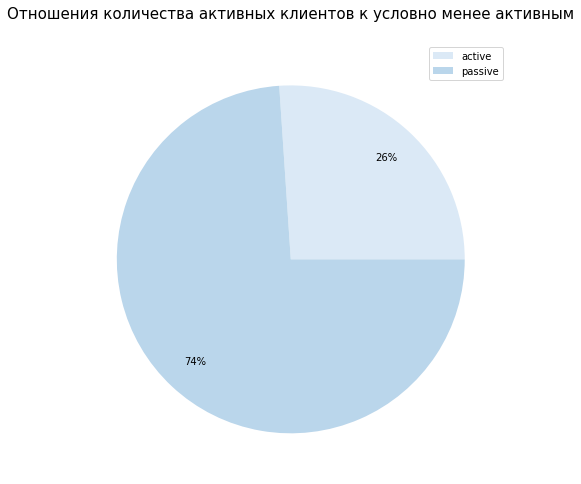

,clients,count
0,active,80
1,passive,227


In [65]:
# создадим таблицу для иллюстрации отношения выделенных активных клиентов к менее активным
clients_active_ratio = pd.DataFrame({
    'clients': ['active', 'passive'], 
    'count': [clients_active['user_id'].count(), revenue_final['user_id'].nunique()-clients_active['user_id'].count()]})

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(clients_active_ratio['count'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Отношения количества активных клиентов к условно менее активным' + "\n", fontsize=15)
plt.legend(clients_active_ratio['clients'])
plt.show()

clients_active_ratio

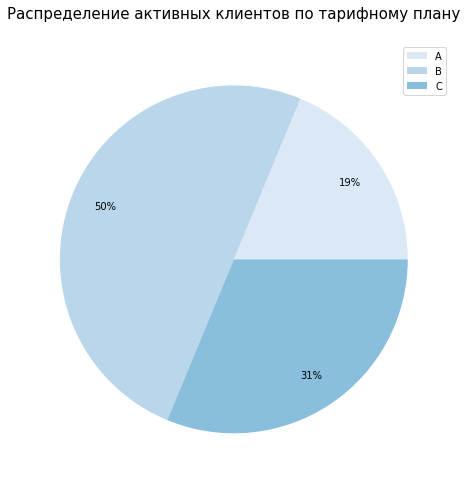

,tariff,user_id
0,A,15
1,B,40
2,C,25


In [66]:
# группируем таблицу сводную таблицу по тарифному плану и посчитаем количество уникальных клиентов
clients_active_tariff = clients_active.groupby('tariff').agg({'user_id':'count'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(clients_active_tariff['user_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение активных клиентов по тарифному плану' + "\n", fontsize=15)
plt.legend(clients_active_tariff['tariff'])
plt.show()

clients_active_tariff

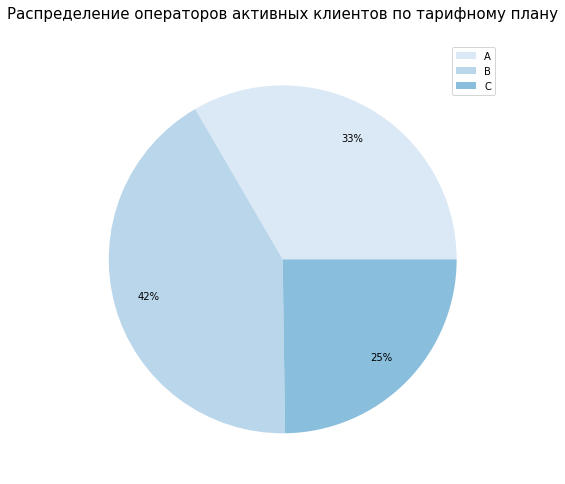

,tariff,operator_id
0,A,190
1,B,238
2,C,141


In [67]:
# группируем сводную таблицу активных клиентов по тарифному плану и посчитаем количество уникальных операторов
operators_active_tariff = clients_active.groupby('tariff').agg({'operator_id':'sum'}).reset_index()

# строим круговую диаграмму 
plt.figure(figsize=(15,8))
colors = sns.color_palette('Blues')
plt.pie(operators_active_tariff['operator_id'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Распределение операторов активных клиентов по тарифному плану' + "\n", fontsize=15)
plt.legend(operators_active_tariff['tariff'])
plt.show()

operators_active_tariff

Выборка данных по пользованию клиентами услуг телефонии содержит 307 клиентов, среди которых наиболее активными является 80 клиентов, что составляют 26%. Распределение по тарифам отличается от распределения общей массы клиентов, так среди активных наибольшее количество клиентов относится к тарифу `В` 50% (40 клиентов) затем `С` 31% (25 клиентов) и наименьшее по `А` 19% (15 клиентов). В рассмотрении количества операторов картина немного изменяется, здесь уже сравниваются клиенты тарифа `В` имеют 238 операторов, что составляет 42% всех активных операторов, по тарифу `А` 190 операторов (33%), 141 оператор на тарифе `С` - 25%.

#### Сравнение среднего месячного потребеления активного клиента со средним по тарифу

Для расчета среднего месячного потребления используем потребление услуг за три месяца с сентября по ноябрь, учитывая горизонт анализа в 3 месяца. Также сравнение будем проводить через среднее от активных клиентов, т.к. нет смысла сравнивать активных клиентов, имеющих большее потреблением услуг, со всеми пользователями.

In [68]:
# таблица средних показателей потребления тарифа активными клиентами за три месяца
usage_tariff = (
    revenue_final.query('month != "2019-08-01" & user_id in @clients_active.user_id')
    .groupby('tariff').agg({'call_in':'mean', 'over_limit':'mean', 'call_out':'mean', 'payment':'mean'})
    .reset_index().round(2)
)

In [69]:
# функция для сравнения потребления услуг клиентом со средним по его тарифу из числа активных клиентов

def difference_usage(clients, dataset, tariff_plan):

    # пустая таблица для записи клиентов превышающих средние трафики по тарифу
    comparison_tariff = pd.DataFrame({
    'user_id': [],
    'tariff': [],
    'month': [],
    'call_in_fact': [],
    'call_out_fact': [],    
    'call_in_over': [],
    'over_limit_over': [],
    'call_out_over': [],
    'payment_over': [] 
    })

    # перебор всех клиентов
    for i in clients['user_id']:
        df_i = dataset.query('user_id == @i').reset_index()
        tariff_i = df_i.loc[0, 'tariff']
        tariff_plan_i = tariff_plan.query('tariff == @tariff_i').reset_index()

        # данные клиента за месяц    
        for j in df_i['month'].unique():
            df_j = df_i.query('month == @j').reset_index()
            
            call_in_fact = df_j.loc[0, 'call_in']
            call_out_fact = df_j.loc[0, 'call_out']            

            call_in = 0
            over_limit = 0
            call_out = 0
            payment = 0

            if df_j.loc[0, 'call_in'] > tariff_plan_i.loc[0, 'call_in']:
                call_in = df_j.loc[0, 'call_in'] - tariff_plan_i.loc[0, 'call_in']
            else:
                call_in = 0

            if df_j.loc[0, 'over_limit'] > tariff_plan_i.loc[0, 'over_limit']:
                over_limit = df_j.loc[0, 'over_limit'] - tariff_plan_i.loc[0, 'over_limit']
            else:
                over_limit = 0

            if df_j.loc[0, 'call_out'] > tariff_plan_i.loc[0, 'call_out']:
                call_out = df_j.loc[0, 'call_out'] - tariff_plan_i.loc[0, 'call_out']
            else:
                call_out = 0

            if df_j.loc[0, 'payment'] > tariff_plan_i.loc[0, 'payment']:
                payment = df_j.loc[0, 'payment'] - tariff_plan_i.loc[0, 'payment']
            else:
                payment = 0
            comparison_tariff.loc[ len(comparison_tariff.index)] = [i, tariff_i, j, call_in_fact, call_out_fact, call_in, over_limit, call_out, payment]

    
    comparison_tariff['user_id'] = comparison_tariff['user_id'].astype(int)
    return comparison_tariff


In [70]:
# применяем функцию 
comparison_tariff = difference_usage(clients_active, revenue_final, usage_tariff)

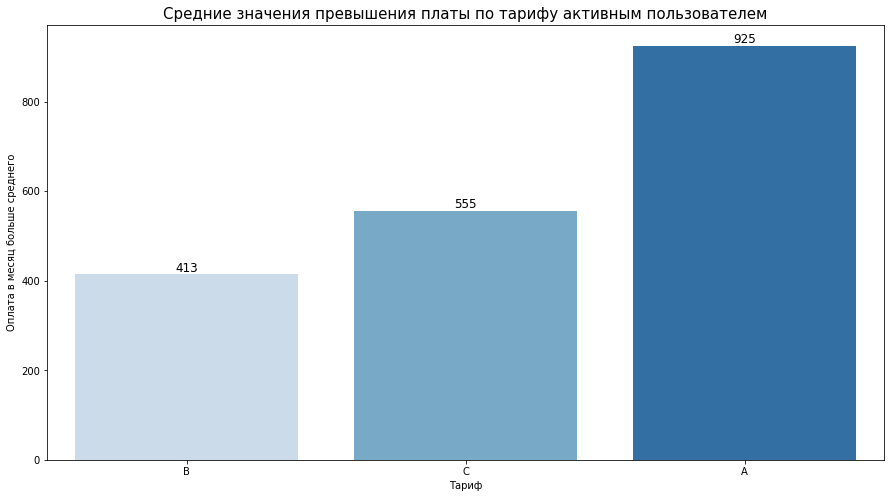

In [71]:
# сгруппируем данные по тарифу для расчета средней переплаты по тарифам
tariff_over_stat = comparison_tariff.groupby('tariff').agg({'payment_over': 'mean'}).sort_values(by='payment_over').reset_index().round(2)

# строим столбчатую диаграмму 
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='tariff', y='payment_over', data=tariff_over_stat, palette='Blues')
for i, val in enumerate(tariff_over_stat['payment_over'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xlabel('Тариф')
plt.ylabel('Оплата в месяц больше среднего')
plt.title('Средние значения превышения платы по тарифу активным пользователем', fontsize=15)
plt.show()

 Таким образом клиенты с тарифом `A` в среднем переплачивают 925 р/мес, клиенты в тарифом `С` переплачивают 555 р/мес, по тарифу  `В` наименьшая переалата и составляет 413 р/мес.

#### Расчет оплаты активного клиента на другом тарифе

Для определения наиболее подходящего тарифа для клиента, рассчитываем потребляемый им трафик за период с сентября по ноябрь, 3 месяца, и определяем плату на каждом тарифе, в сравнении выбираем тариф с наименьшей платой. Для этого прописываем функцию, которой передаем потребляемые клиентом услуги за три месяца и условия тарифного плана. На выходе функция выдает таблицу с данными по каждому клиенту: тариф, плата на текущем тарифе, выгодный тариф, плана на выгодном тарифе.

In [72]:
# функция для сравнения оплаты услуг клиентом на разных тарифах

def difference_usage(df, tariff_plan):

    # пустая таблица для записи клиентов превышающих средние трафики по тарифу
    client_analys = pd.DataFrame({
    'user_id': [],
    'tariff': [],        
    'payment_A': [],
    'payment_B': [],    
    'payment_C': [],
    'best_tariff': [],
    'best_payment': [],
    'revenue_fact': []    
    })

    # перебор всех клиентов
    for i in df['user_id'].unique():
        df_i = df.query('user_id == @i').reset_index()
        tariff_i = df_i.loc[0, 'tariff_plan']
        month = df_i.loc[0, 'month']        

        # плата на тарифе А
        revenue_A = (tariff_plan.loc[0, 'payment'] * month # ежемесячная оплата тарифа умножается на кол-во месяцев работы клиента
                    + df_i.loc[0, 'operators'] * tariff_plan.loc[0, 'payment_operator'] # доплата за каждого оператора
                    + df_i.loc[0, 'call_out'] * tariff_plan.loc[0, 'outgoing_call'] # оплата исходящих звонков вне сети
                    )
        #условием проверяем перерасход лимита исходящих звонков внутри сети и добавляем результат к выручке за месяц
        if df_i.loc[0, 'call_in'] > tariff_plan.loc[0, 'call_network']:
            revenue_A += (df_i.loc[0, 'call_in'] - tariff_plan.loc[0, 'call_network']) * tariff_plan.loc[0, 'price_over_limit']                
        else:
            revenue_A += 0

        # плата на тарифе В
        revenue_B = (tariff_plan.loc[1, 'payment'] * month
                    + df_i.loc[0, 'operators'] * tariff_plan.loc[1, 'payment_operator'] 
                    + df_i.loc[0, 'call_out'] * tariff_plan.loc[1, 'outgoing_call']
                    )
           
        if df_i.loc[0, 'call_in'] > tariff_plan.loc[1, 'call_network']:
            revenue_B += (df_i.loc[0, 'call_in'] - tariff_plan.loc[1, 'call_network']) * tariff_plan.loc[1, 'price_over_limit']                
        else:
            revenue_B += 0 

        # плата на тарифе С
        revenue_C = (tariff_plan.loc[2, 'payment'] * month
                    + df_i.loc[0, 'operators'] * tariff_plan.loc[2, 'payment_operator'] 
                    + df_i.loc[0, 'call_out'] * tariff_plan.loc[2, 'outgoing_call'] 
                    + df_i.loc[0, 'call_in'] * tariff_plan.loc[2, 'price_over_limit'])      

        # сравнение и определение наименьшей платы          
        if revenue_A < revenue_B and revenue_A < revenue_C:
            best = 'A'
            best_payment = revenue_A
        elif revenue_B < revenue_A and revenue_B < revenue_C:
            best = 'B'
            best_payment = revenue_B
        else:
            best = 'C'
            best_payment = revenue_C
        
        # определение фактической платы
        if tariff_i == 'A':
            revenue_fact = revenue_A
        elif tariff_i == 'B':
            revenue_fact = revenue_B
        else:
            revenue_fact = revenue_C
        
        # добавление данных в таблицу по каждому клиенту
        client_analys.loc[ len(client_analys.index)] = [i, tariff_i, revenue_A, revenue_B, revenue_C, best, best_payment, revenue_fact]

    client_analys['user_id'] = client_analys['user_id'].astype(int)    
    return client_analys

In [73]:
# подготовим таблицу для передачи функции 
# таблица активных клиентов содержит данные о потребленных услугах за три месяца,
# количество исходящих внутренних и внешних звонков, количество операторов и текущий тариф
# важно, что для расчета общее количество операторов, т.к. расчет для периода, а не для месяца
df_period = (
    (revenue_final.query('user_id in @clients_active.user_id & month != "2019-08-01"')
    .groupby('user_id').agg({'call_in':'sum', 'call_out':'sum', 'operators':'sum', 'month':'count'}).reset_index())
    .merge(clients, on='user_id', how='left')
    )

In [74]:
# применяем функцию
client_analys = difference_usage(df_period, tariff_plan)

In [75]:
# оставляем в таблице клиентов с измененным выгодным тарифом
client_analys_change = client_analys.query('best_tariff != tariff')

# выводим первые 10 записей
client_analys_change.head(10)

,user_id,tariff,payment_A,payment_B,payment_C,best_tariff,best_payment,revenue_fact
2,166407,A,13364.6,9941.0,10877.8,B,9941.0,13364.6
4,166503,B,12938.2,8497.0,7767.2,C,7767.2,8497.0
5,166511,C,15156.9,12061.5,12570.0,B,12061.5,12570.0
6,166520,C,15173.1,13488.5,16455.4,B,13488.5,16455.4
7,166536,B,12932.9,8221.5,7014.0,C,7014.0,8221.5
8,166541,A,12674.1,7923.5,6774.1,C,6774.1,12674.1
9,166658,B,23634.8,28658.0,39131.2,A,23634.8,28658.0
10,166678,B,13090.0,8750.0,8114.2,C,8114.2,8750.0
13,166782,C,14434.8,11058.0,11431.8,B,11058.0,11431.8
14,166800,B,12872.9,8521.5,7970.1,C,7970.1,8521.5


In [76]:
# выведем количество уникальных клиентов, для которых подходит другой тариф
print(f'Количество клиентов, для которых более выгоден другой тариф: {client_analys_change["user_id"].count()}')

Количество клиентов, для которых более выгоден другой тариф: 52


Проанализиров трафик активных клиентов за три месяца и проведя расчет оплаты потребленного трафика на всех типах тарифа, для 51 клиентов из числа активных клиентов выгодным является другой тариф. 

### Шаг 5. Расчет выгоды для активных клиентов при переводе на более выгодный для них тариф

#### Расходы клиента при переходе на другой тариф с текущими показателями потребления услуг

Для удобства анализа разделим клиентов по группам смены тарифа, для начала проверим, с каких и на кикие тарифы выгодно перейти клиентам.

In [77]:
# клиенты с тарифа `А` на тариф `В`
a_b = client_analys_change.query('tariff == "A" & best_tariff == "B"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `А` на тариф `В`: {a_b}')

# клиенты с тарифа `А` на тариф `C`
a_c = client_analys_change.query('tariff == "A" & best_tariff == "C"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `А` на тариф `C`: {a_c}')

# клиенты с тарифа `B` на тариф `A`
b_a = client_analys_change.query('tariff == "B" & best_tariff == "A"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `B` на тариф `A`: {b_a}')

# клиенты с тарифа `B` на тариф `C`
b_c = client_analys_change.query('tariff == "B" & best_tariff == "C"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `B` на тариф `C`: {b_c}')

# клиенты с тарифа `C` на тариф `A`
c_a = client_analys_change.query('tariff == "C" & best_tariff == "A"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `C` на тариф `A`: {c_a}')

# клиенты с тарифа `C` на тариф `В`
c_b = client_analys_change.query('tariff == "C" & best_tariff == "B"')['user_id'].count()
print(f'Количество клиентов для перехода с тарифа `C` на тариф `В`: {c_b}')


Количество клиентов для перехода с тарифа `А` на тариф `В`: 5
Количество клиентов для перехода с тарифа `А` на тариф `C`: 6
Количество клиентов для перехода с тарифа `B` на тариф `A`: 2
Количество клиентов для перехода с тарифа `B` на тариф `C`: 28
Количество клиентов для перехода с тарифа `C` на тариф `A`: 0
Количество клиентов для перехода с тарифа `C` на тариф `В`: 11


Итого для 5 клиентов выгодно перейти с `A` на `B` и для 6 на `C`. Выгодным считается переход с `B` на тариф `А` для 2 клиентов и для 28 на тариф `C`. Переход с тарифа `C` на тариф `B` для 11 клиентов принесет экономию средств. Клиентов, для которых выгоднен переход с тарифа `C` на тариф `A` не нашлось. 

#### Расходы клиента при переходе на другой тариф с текущими показателями потребления услуг

Для каждой группе перехода на альтернативный тариф расчитываем % снижения платы.

Группа перехода `А` на тариф `В`

In [78]:
a_b = round((100 - 
    client_analys_change.query('tariff == "A" & best_tariff == "B"')['best_payment']/
    client_analys_change.query('tariff == "A" & best_tariff == "B"')['revenue_fact']*100).mean(), 2)
print(f'При переходе с тарифа `А` на тариф `В` клиенты в среднем будут платить меньше на {a_b}%')

При переходе с тарифа `А` на тариф `В` клиенты в среднем будут платить меньше на 21.93%


Группа перехода `A` на тариф `C`

In [79]:
a_c = round((100 - 
    client_analys_change.query('tariff == "A" & best_tariff == "C"')['best_payment']/
    client_analys_change.query('tariff == "A" & best_tariff == "C"')['revenue_fact']*100).mean(), 2)
print(f'При переходе с тарифа `А` на тариф `C` клиенты в среднем будут платить меньше на {a_c}%')

При переходе с тарифа `А` на тариф `C` клиенты в среднем будут платить меньше на 46.92%


Группа перехода `В` на тариф `А`

In [80]:
b_a = round((100 - 
    client_analys_change.query('tariff == "B" & best_tariff == "A"')['best_payment']/
    client_analys_change.query('tariff == "B" & best_tariff == "A"')['revenue_fact']*100).mean(), 2)
print(f'При переходе с тарифа `В` на тариф `А` клиенты в среднем будут платить меньше на {b_a}%')

При переходе с тарифа `В` на тариф `А` клиенты в среднем будут платить меньше на 12.67%


Группа перехода `В` на тариф `C`

In [81]:
b_c = round((100 - 
    client_analys_change.query('tariff == "B" & best_tariff == "C"')['best_payment']/
    client_analys_change.query('tariff == "B" & best_tariff == "C"')['revenue_fact']*100).mean(), 2)
print(f'При переходе с тарифа `В` на тариф `C` клиенты в среднем будут платить меньше на {b_c}%')

При переходе с тарифа `В` на тариф `C` клиенты в среднем будут платить меньше на 14.53%


Группа перехода `C` на тариф `В`

In [82]:
c_b = round((100 - 
    client_analys_change.query('tariff == "C" & best_tariff == "B"')['best_payment']/
    client_analys_change.query('tariff == "C" & best_tariff == "B"')['revenue_fact']*100).mean(), 2)
print(f'При переходе с тарифа `C` на тариф `В` клиенты в среднем будут платить меньше на {c_b}%')

При переходе с тарифа `C` на тариф `В` клиенты в среднем будут платить меньше на 10.41%


#### Выгода клиента при переходе на другой тариф

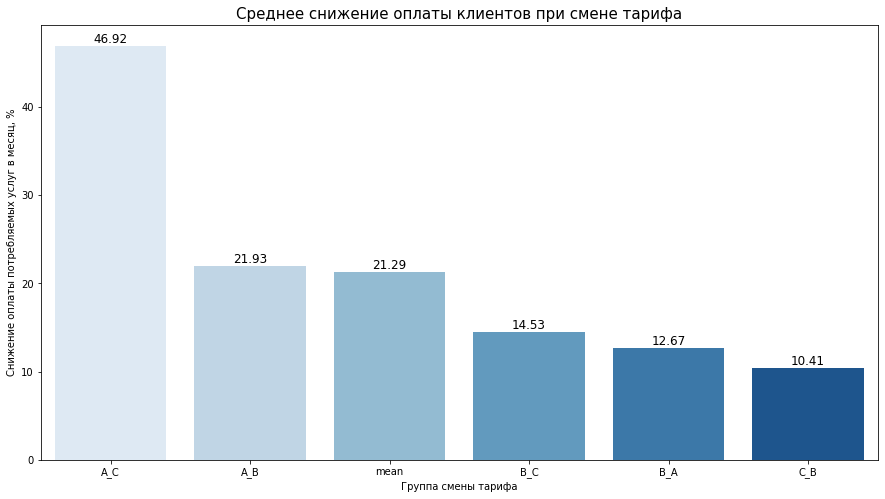

In [83]:
# подготавливаем таблицу снижения оплаты клиентов при переходе с тарифа на тариф
clients_tariff_change = pd.DataFrame({
    'user_group': ['A_B', 'A_C', 'B_A', 'B_C', 'C_B', 'mean'],
    'benefit': [a_b, a_c, b_a, b_c, c_b,
                round(sum([a_b, a_c, b_a, b_c, c_b])/len([a_b, a_c, b_a, b_c, c_b]),2)
    ]}).sort_values(by='benefit', ascending=False)

# строим столбчатую диаграмму 
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='user_group', y='benefit', data=clients_tariff_change, palette='Blues')
for i, val in enumerate(clients_tariff_change['benefit'].values):
    plt.text(i, val, round(val,2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xlabel('Группа смены тарифа')
plt.ylabel('Снижение оплаты потребляемых услуг в месяц, %')
plt.title('Среднее снижение оплаты клиентов при смене тарифа', fontsize=15)
plt.show()

Наиболее выгодным является переход на другой тариф для клиентов с тарифом `A`, так для одних на тарифе `C` снизятся плата на 46,92%, для других на тарифе `В` снижается на 21.93%. Для клиентов с тарифом `В`: для одних переход на `А` будет означать снижение оплаты на 12.67%, для других переход на `C` на 14.53%. Для активных клиентов с тарифом `C` уменьшение трат на оплату услуг на тарифе `В` составит 10,41%. В среднем, при переводе клиенты будут платить на 21,29% меньше.

### Шаг 6. Определение изменения выручки компании при переводе активных клиентов на другие тарифы

Для определения изменения выручки при смене тарифа активных клиентов, следует для начала привести расчет выручки по остальным клиентам к формату выручки за три месяца. Для этого применим функцию расчета платы за три месяца, оставим столбец с клиентами и платой по текущему тарифу, так рассчитаем текущую выручку компании. Далее присоединим к таблице плату на более выгодном тарифе для активных клиентов, с сохранением текущей платы для пассивных клиентов.

In [84]:
# подготовим таблицу для передачи функции 
# таблица всех клиентов, содержит данные о потребленных услугах за три месяца,
# количество исходящих внутренних и внешних звонков, количество операторов и текущий тариф
# важно, что для расчета общее количество операторов, т.к. расчет для периода, а не для месяца
df_period_clients = (
    (revenue_final.query('month != "2019-08-01"')
    .groupby('user_id').agg({'call_in':'sum', 'call_out':'sum', 'operators':'sum', 'month':'count'}).reset_index())    
    .merge(clients, on='user_id', how='left')
    )

In [85]:
# применяем функцию для расчета общей платы каждого клиента за три месяца
client_analys_notchange = difference_usage(df_period_clients, tariff_plan)

In [86]:
# подготовим таблицу для передачи функции 
# таблица всех клиентов, содержит данные о потребленных услугах за три месяца,
# количество исходящих внутренних и внешних звонков, количество операторов и текущий тариф
# важно, что для расчета общее количество операторов, т.к. расчет для периода, а не для месяца
df_period_clients = (
    (revenue_final.query('month != "2019-08-01"')
    .groupby('user_id').agg({'call_in':'sum', 'call_out':'sum', 'operators':'sum', 'month':'count'}).reset_index())    
    .merge(clients, on='user_id', how='left')
    )

# применяем функцию для расчета общей платы каждого клиента за три месяца
client_analys_notchange = difference_usage(df_period_clients, tariff_plan)

# оставляет в таблице только столбцы с id клиента и суммой платы по текущему тарифу, переименовываем столбец с платой
client_analys_before = client_analys_notchange[['user_id', 'tariff', 'revenue_fact']]
client_analys_before.columns = ['user_id', 'tariff_before', 'revenue_before']

# таблица активных клиентов,
# оставляет в таблице только столбцы с id клиента и суммой платы на лучшем тарифе, переименовываем столбец с платой 
client_analys_after = client_analys_change[['user_id', 'tariff', 'best_payment']]
client_analys_after.columns = ['user_id', 'tariff_after', 'revenue_after']

# объединяем всех клиентов 
revenue_analys = client_analys_before.merge(client_analys_after, on='user_id', how='outer')

# получили таблицу с текущей выручкой по клиентам 
# и выручкой со сменой тарифа на более выгодный клиенту
# заполним пропуски в столбце с выручкой после смены тарифа значениями первого столбца (плата по текущему)
revenue_analys['revenue_after'] = revenue_analys['revenue_after'].fillna(revenue_analys['revenue_before'])
revenue_analys['tariff_after'] = revenue_analys['tariff_after'].fillna(revenue_analys['tariff_before'])

# выведем первые значения таблицы
revenue_analys.head()

,user_id,tariff_before,revenue_before,tariff_after,revenue_after
0,166377,B,10904.0,B,10904.0
1,166391,C,4500.0,C,4500.0
2,166392,C,5700.0,C,5700.0
3,166399,C,3200.0,C,3200.0
4,166405,B,17296.0,B,17296.0


#### Определение выручки компании при смене тарифного плана активных клиентов

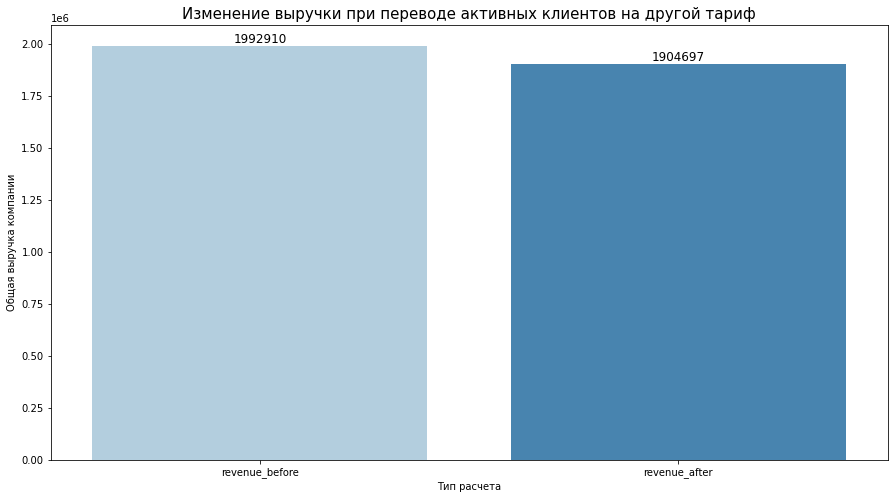

In [87]:
# подготавливаем таблицу общей выручки за три месяца до и после смены тарифа активных клиентов
revenue_analys_change = pd.DataFrame({
    'revenue': ['revenue_before', 'revenue_after'],
    'revenue_sum': [revenue_analys['revenue_before'].sum().round(2), revenue_analys['revenue_after'].sum().round(2)]})

# строим столбчатую диаграмму 
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='revenue', y='revenue_sum', data=revenue_analys_change, palette='Blues')
for i, val in enumerate(revenue_analys_change['revenue_sum'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.xlabel('Тип расчета')
plt.ylabel('Общая выручка компании')
plt.title('Изменение выручки при переводе активных клиентов на другой тариф', fontsize=15)
plt.show()

Определим также процентное соотношение получаемой выручки по тарифам.

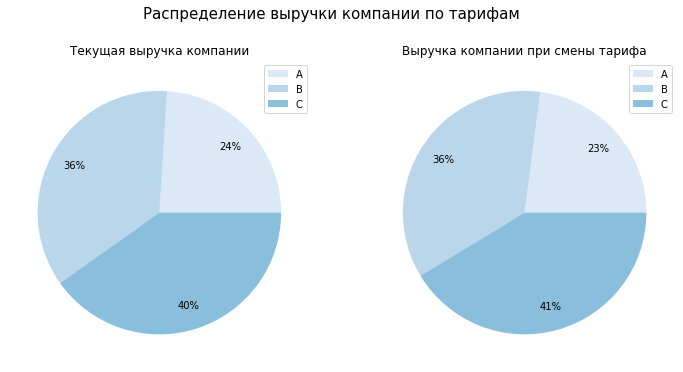

In [88]:
# подготовка таблиц для расчета распределения выручки компании до и после смены тарифа активных пользователей
revenue_before = revenue_analys.groupby('tariff_before').agg({'revenue_before':'sum'}).reset_index()
revenue_after = revenue_analys.groupby('tariff_after').agg({'revenue_after':'sum'}).reset_index()


# график средних показателей по исходящим внутренним звонкам оператора в месяц
plt.figure(figsize=(12, 6))
colors = sns.color_palette('Blues')
plt.suptitle('Распределение выручки компании по тарифам' + "\n"*2, fontsize=15)

ax1 = plt.subplot(1, 2, 1)
plt.pie(revenue_before['revenue_before'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Текущая выручка компании')
plt.legend(revenue_before['tariff_before'])

ax1 = plt.subplot(1, 2, 2)
plt.pie(revenue_after['revenue_after'], colors = colors, pctdistance=0.8, radius=1, autopct = '%0.0f%%')
plt.title('Выручка компании при смены тарифа')
plt.legend(revenue_after['tariff_after'])


plt.show()

Текущая выручка компании с августа по ноябрь составила 1 992 910, при изменении тарифа активных пользователей выручка компании составила бы 1 904 697 р. В рассмотрении распределения по тарифам после смены клиенты тарифа `A` будут приносить не 24, а 23%. Клиенты по тарифу `C` увеличат свою долю в выручке компании на 1% до 41%.

#### Расчет изменения выручки компании

In [89]:
# изменение выручки за три месяца при переводе активных клиентов на вогодный для них тариф
revenue_analys_value = round((100 - 
    revenue_analys_change.loc[1, 'revenue_sum']/
    revenue_analys_change.loc[0, 'revenue_sum']*100).mean(), 2)
print(f'При переводе активных клиентов на выгодный для них тариф выручка компании за период в три месяца снизится на '
      f'{revenue_analys_value}%')

При переводе активных клиентов на выгодный для них тариф выручка компании за период в три месяца снизится на 4.43%


Изменение тарифного плана активных клиентов снижает их оплату по потребляемым услугам, соответственно снижается общая выручка компании. В рассмотрении перевода 52 клиентов на альтернативный териф выручка снижается на 4,43%.

### Шаг 7. проверка статистических гипотез

Чтобы проверить гипотезы о равенстве средних двух генеральных совокупностей для зависимых (парных) выборок, применим t-критерий для парных выборок методом `scipy.stats.ttest_rel()`.

#### Гипотеза 1: Текущая общая выручка компании не отличается от выручки компании после смены тарифа активных клиентов.

Сформулируем нулевую и альтернативную гипотезы:

0. Нулевая гипотеза H₀: Выручка компании до и после смены тарифа одинакова;
1. Альтернативная гипотеза H₁: Выручка компании до смены тарифа и после отличаются.

In [90]:
# массив данных до смены тарифа
before = revenue_analys['revenue_before'].tolist()
# массив данных после смены тарифа
after = revenue_analys['revenue_after'].tolist()

Статистические показатели выборок

Объем выборки до: 303
Объем выборки после: 303

Среднее значение выборки до: 6577.26
Среднее значение выборки после: 6286.13

Максимальное и минимальное значение выборки до: (60912.0, 1300.0)
Максимальное и минимальное значение выборки после: (60912.0, 1300.0)

Дисперсия выборки до: 29468553.01
Дисперсия выборки после: 27661971.0



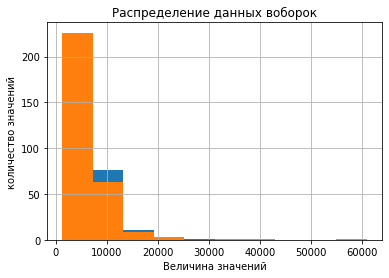

In [91]:
# объем сравниваемых выборок
print(f'Объем выборки до: {len(before)}')
print(f'Объем выборки после: {len(after)}')
print()
# средние значения выборок
print(f'Среднее значение выборки до: {round(sum(before)/len(before), 2)}')
print(f'Среднее значение выборки после: {round(sum(after)/len(after), 2)}')
print()
# аномальные значания выборок
print(f'Максимальное и минимальное значение выборки до: {max(before), min(before)}')
print(f'Максимальное и минимальное значение выборки после: {max(after), min(after)}')
print()
# дисперсия выборок
print(f'Дисперсия выборки до: {round(np.var(before, ddof=1),2)}')
print(f'Дисперсия выборки после: {round(np.var(after, ddof=1),2)}')
print()
# распределение данных выборок
revenue_analys['revenue_before'].hist()
revenue_analys['revenue_after'].hist()

plt.xlabel('Величина значений')
plt.ylabel('количество значений')
plt.title('Распределение данных воборок');

Распределение данных выборок смещено влево. Минимальные значения совпадают, в максимальное `после` меньше. Также среднее значение и дисперсия `после` меньше.

In [92]:
# проводим t-тест для парных выборок

alpha = 0.05 # уровень статистической значимости

results = st.ttest_rel(before, after)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.2381257420371814e-08
Отвергаем нулевую гипотезу


Поскольку p-значение ( 0.00001 ) меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что средняя выручка отличается при текущих тарифах клиента и при изменении тарифа активных клиентов.

#### Гипотеза 2: Выручка компании по активным клиентам на текущем тарифе не отличается от выручки по этим клиентам после смены тарифа.

Сформулируем нулевую и альтернативную гипотезы:

0. Нулевая гипотеза H₀: Выручка компании от активных клиентов до и после смены тарифа одинакова;
1. Альтернативная гипотеза H₁: Выручка компании от активных клиентов до смены тарифа и после отличаются.

In [93]:
# подготовим данные, выделим из таблицы только активных клиентов со сменой тарифа
stat_analys = revenue_analys.query('user_id in @client_analys_change.user_id')

# массив данных до смены тарифа
before_2 = stat_analys['revenue_before'].tolist()
# массив данных после смены тарифа
after_2 = stat_analys['revenue_after'].tolist()

Статистические показатели выборок

Объем выборки до: 52
Объем выборки после: 52

Среднее значение выборки до: 9336.64
Среднее значение выборки после: 7640.25

Максимальное и минимальное значение выборки до: (28658.0, 2639.5)
Максимальное и минимальное значение выборки после: (23634.8, 2165.3)

Дисперсия выборки до: 16091754.91
Дисперсия выборки после: 12508855.98



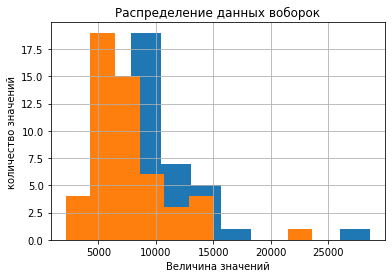

In [94]:
# объем сравниваемых выборок
print(f'Объем выборки до: {len(before_2)}')
print(f'Объем выборки после: {len(after_2)}')
print()
# средние значения выборок
print(f'Среднее значение выборки до: {round(sum(before_2)/len(before_2), 2)}')
print(f'Среднее значение выборки после: {round(sum(after_2)/len(after_2), 2)}')
print()
# аномальные значания выборок
print(f'Максимальное и минимальное значение выборки до: {max(before_2), min(before_2)}')
print(f'Максимальное и минимальное значение выборки после: {max(after_2), min(after_2)}')
print()
# дисперсия выборок
print(f'Дисперсия выборки до: {round(np.var(before_2, ddof=1),2)}')
print(f'Дисперсия выборки после: {round(np.var(after_2, ddof=1),2)}')
print()
# распределение данных выборок
stat_analys['revenue_before'].hist()
stat_analys['revenue_after'].hist()

plt.xlabel('Величина значений')
plt.ylabel('количество значений')
plt.title('Распределение данных воборок');

Выборка активных клиентов для смены тарифа отличается более высокими значениями по среднему, минимальному и максимальному значению. Дисперсия в несколько раз умеьшается после смены тарифа.

In [95]:
# проводим t-тест для парных выборок

alpha = 0.05 # уровень статистической значимости

results = st.ttest_rel(before_2, after_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 5.08852631277342e-11
Отвергаем нулевую гипотезу


Поскольку p-значение ( 0.000001 ) меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что средняя выручка по активным киентам отличается при текущих тарифах клиента и при изменении тарифа.

### Шаг 8. Выводы. Рекомендации по снижению падения выручки

Компания предлагает клиентам услуги телефонии по трем тарифам, наибольшей популярностью среди которых пользуется тариф `C`, затем идет тариф `B` и `A`. По количеству операторов разница между тарифами снижается и распределяется практически в равной доли, исключая тариф `A`, по нему меньше операторов.

Выручка компании изменяется такими же темпами, как и рост количества клиентов и операторов, использующих услуги телефонии. Так наблюдается стремительный рост выручки с августа по ноябрь. Средняя выручка за месяц за 4 месяца составляет 552614р, но если не брать в расчет разгоночный месяц август, то средняя выручка равна 664261р.

Наибольший вклад в прибыль компании приносят клиенты по тарифу `В` (37%) и `С` (39)%, наименьший по тарифу `A` (24%).

Для последующего удержания наиболее активных клиентов был проанализирован трафик потребления ими услуг телефонии и сопоставлен с тарифными планами, в результате чего было выявлено 52 активных пользователей, для которых наиболее выгодным считается другой тариф. Среднее снижение платы для них составит 21%.

Проверены статистические гипотезы о том, что выручка компании не изменится, при переводе клиентов на альтернативный тариф. Гипотезы опровергнуты. Данные оплаты клиентов за три месяца превышает плату после смены тарифа. 

При переводе активных клиентов на более выгодный для них тариф выручка компании за период в три месяца снизится на 4,43%.

Предложение о смене тарифа, следует предусмотреть для клиентов активно превосходящих средние трафики по их текущему тарифу также среди активных клиентов.

Рекомендация: разрабатывать предложение для клиентов, выгода которых при переходе на тариф составляет более 15%. 

### Шаг 9. Оформление дашборда и предоставление отчетной презентации заказчику

[Презентация проекта](https://drive.google.com/file/d/1BGWM3fgxxb-LNZhQMYqL0DFdElaqnfzv/view?usp=share_link)

[Дашборд проекта](https://public.tableau.com/views/DashboardTelecom03_02/DashboardTelecom?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)